In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/LSTM/finalday31.csv')
#df['loggingTime(txt)'] = df['loggingTime(txt)'].dt.tz_localize(None)
#df.set_index('loggingTime(txt)', inplace=True)
data = df[['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
           'gyroRotationX(rad/s)','gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
           'motionYaw(rad)','motionRoll(rad)','motionPitch(rad)']]

def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        window_data = df_as_np[i:i + window_size]
        X.append(window_data)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 8
X, y = df_to_X_y(data, WINDOW_SIZE)


# Data Splitting

In [ ]:
total_samples = len(X)
train_samples = int(0.7 * total_samples)
val_samples = int(0.15 * total_samples)
test_samples = total_samples - train_samples - val_samples

X_train, y_train = X[:train_samples], y[:train_samples]
X_val, y_val = X[train_samples:train_samples + val_samples], y[train_samples:train_samples + val_samples]
X_test, y_test = X[train_samples + val_samples:], y[train_samples + val_samples:]

# Data Scaling

In [ ]:
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
# X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test


# Adaboost regressor initialization

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost classifier
ada = AdaBoostRegressor()

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1.0],
    'base_estimator__max_depth': [1, 2, 3]
}


In [ ]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
y_train.shape[1]

In [ ]:
adaboost_models = []
for i in range(y_train.shape[1]):
    adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.01, loss='exponential')
    adaboost_model.fit(X_train_scaled.reshape(X_train_scaled.shape[0], -1), y_train[:, i])
    adaboost_models.append(adaboost_model)

# Predictions

In [ ]:
# Make predictions
train_predictions = np.column_stack([model.predict(X_train_scaled.reshape(X_train_scaled.shape[0], -1)) for model in adaboost_models])
val_predictions = np.column_stack([model.predict(X_val_scaled.reshape(X_val_scaled.shape[0], -1)) for model in adaboost_models])
test_predictions = np.column_stack([model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], -1)) for model in adaboost_models])


In [ ]:
# Calculate residuals for each output variable
train_residuals = y_train - train_predictions
val_residuals = y_val - val_predictions
test_residuals = y_test - test_predictions

In [ ]:
test_predictions.shape

(1746, 9)

In [ ]:
y_test

array([[-0.23808289,  0.0459137 , -1.02124023, ...,  2.96198575,
        -0.22798345, -0.13825055],
       [-0.33586121,  0.01734924, -0.93566895, ...,  2.94777691,
        -0.24344   , -0.1464897 ],
       [-0.16795349,  0.12890625, -0.8742218 , ...,  2.94317649,
        -0.24896531, -0.1510794 ],
       ...,
       [-0.02932739,  0.020401  , -1.0400238 , ...,  0.96951867,
        -0.0046719 , -0.04003588],
       [-0.10891724,  0.05607605, -0.927948  , ...,  0.96373435,
        -0.01000986, -0.03679408],
       [-0.05465698,  0.05355835, -0.77108765, ...,  0.96159839,
        -0.0212781 , -0.03909432]])

In [ ]:
# Plotting actual vs predicted for each parameter
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

num_outputs = test_predictions.shape[1]

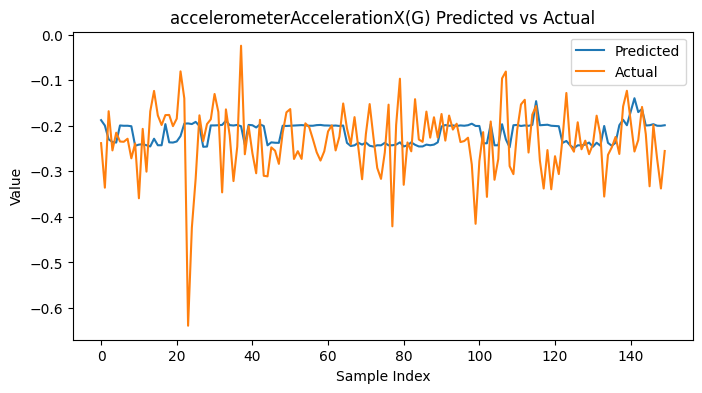

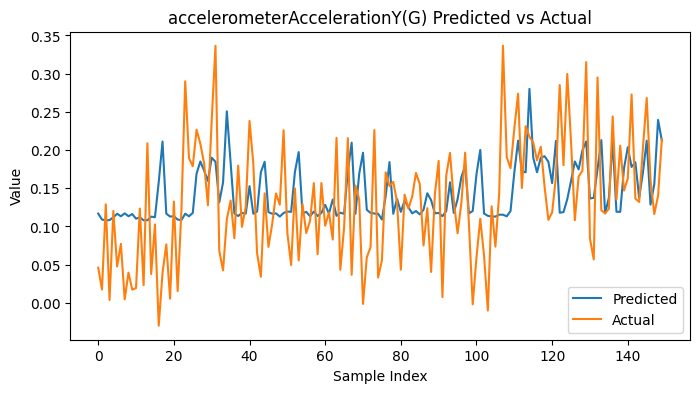

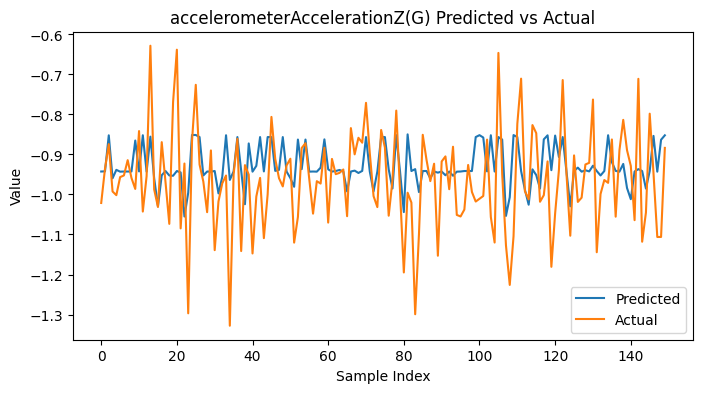

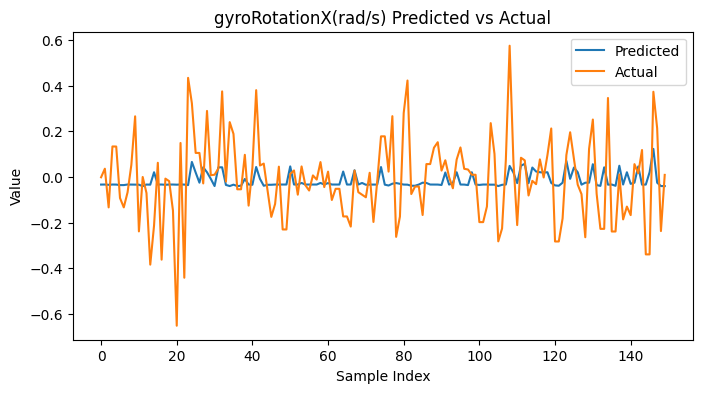

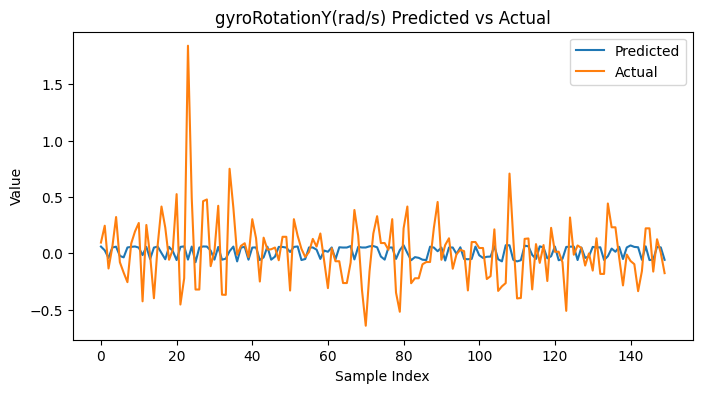

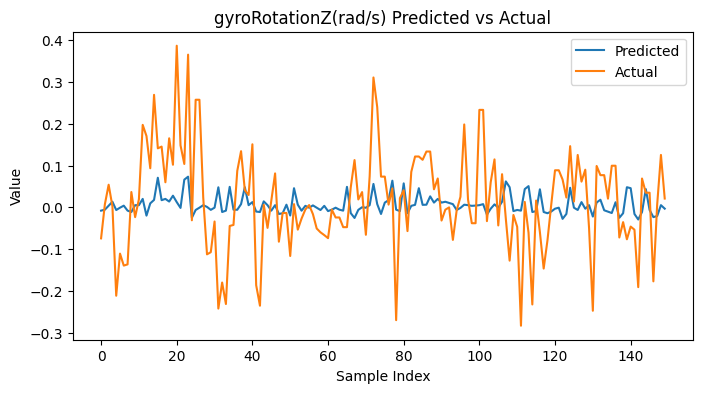

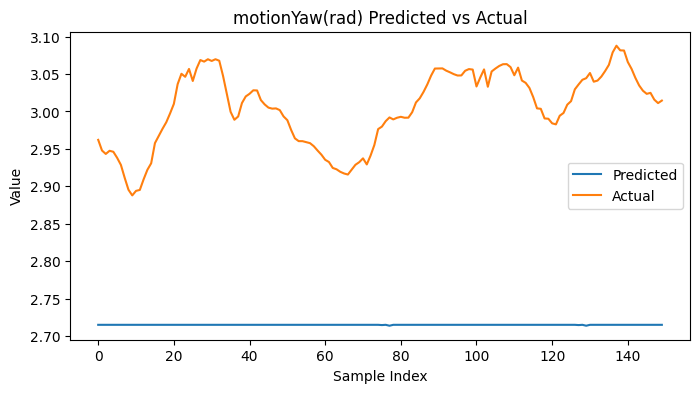

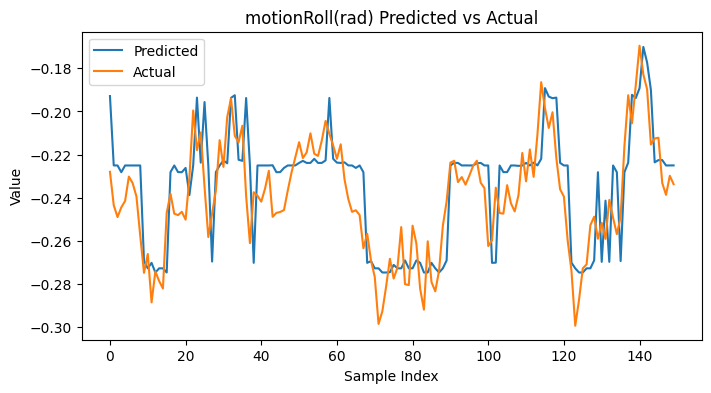

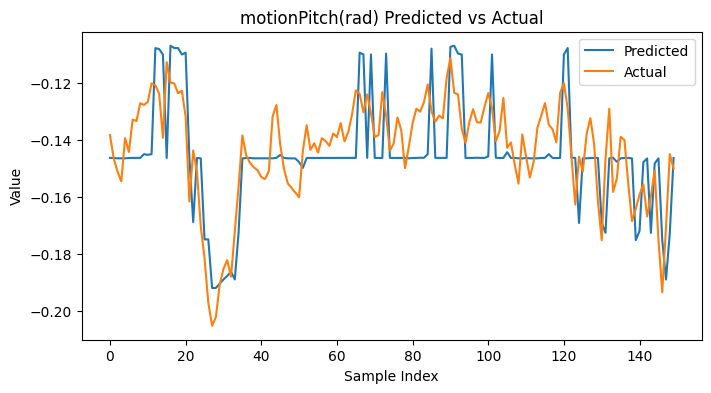

In [ ]:
for i in range(num_outputs):
    # Create a DataFrame with predicted and actual values for the current output
    output_data = pd.DataFrame(data={'Predicted': test_predictions[:, i], 'Actual': y_test[:, i]})

    # Plot predicted and actual values
    plt.figure(figsize=(8, 4))
    plt.plot(output_data['Predicted'][:150], label='Predicted')
    plt.plot(output_data['Actual'][:150], label='Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'{output_labels[i]} Predicted vs Actual')
    plt.legend()
    plt.show()


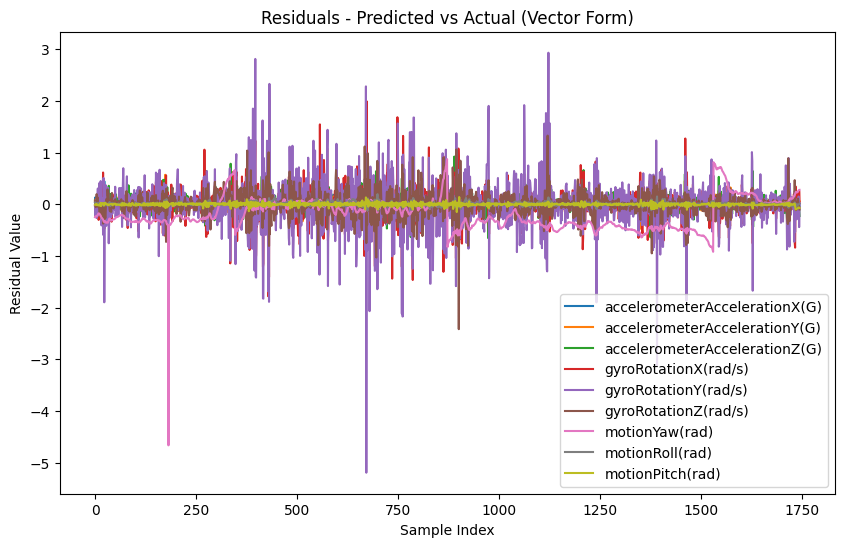

Anomaly Percentage for accelerometerAccelerationX(G): 0.06%
Anomaly Percentage for accelerometerAccelerationY(G): 0.63%
Anomaly Percentage for accelerometerAccelerationZ(G): 2.00%
Anomaly Percentage for gyroRotationX(rad/s): 9.22%
Anomaly Percentage for gyroRotationY(rad/s): 18.27%
Anomaly Percentage for gyroRotationZ(rad/s): 3.67%
Anomaly Percentage for motionYaw(rad): 12.37%
Anomaly Percentage for motionRoll(rad): 0.00%
Anomaly Percentage for motionPitch(rad): 0.00%


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you already have X2 and y2 defined
#test_predictions = np.column_stack([model.predict(X2.reshape(X2.shape[0], -1)) for model in adaboost_models])
test_predictions = np.column_stack([model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], -1)) for model in adaboost_models])

output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

all_residuals = []  # List to store residuals for each output

# Dictionary to store anomaly percentages for each output
anomaly_percentages = {}

for i in range(y_test.shape[1]):
    # Select the column corresponding to the current output from test_predictions
    predicted_column = test_predictions[:, i]

    # Select the column corresponding to the current output from y2
    actual_column = y_test[:, i]

    # Calculate residuals in vector form
    residuals = predicted_column - actual_column
    all_residuals.append(residuals)

    # Calculate the percentage of anomalies based on a threshold
    threshold = 0.5  # Adjust the threshold based on your requirements
    anomalies = (np.abs(residuals) > threshold).astype(int)
    anomaly_percentage = np.mean(anomalies) * 100
    anomaly_percentages[output_labels[i]] = anomaly_percentage


# Convert the list of residuals into a NumPy array for further analysis if needed
all_residuals = np.array(all_residuals)

# Visualize the residuals in vector form
plt.figure(figsize=(10, 6))
plt.plot(all_residuals.T, label=output_labels)
plt.xlabel('Sample Index')
plt.ylabel('Residual Value')
plt.title('Residuals - Predicted vs Actual (Vector Form)')
plt.legend()
plt.show()

# Print anomaly percentages
for output_label, percentage in anomaly_percentages.items():
    print(f"Anomaly Percentage for {output_label}: {percentage:.2f}%")


In [ ]:
# Calculate residuals between predicted and actual outputs
residuals = test_predictions - y_test

# Define a threshold for anomaly detection
threshold = 0.5  # Change this value based on your analysis

# Identify anomalies based on the threshold
anomalies = np.abs(residuals) > threshold

# Calculate the percentage of anomalies detected
percentage_anomalies = np.mean(anomalies) * 100

print(f"Percentage of anomalies detected: {percentage_anomalies:.2f}%")

Percentage of anomalies detected: 5.14%


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Define the number of splits for time series cross-validation
n_splits = 5  # You can adjust this based on your preference

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize AdaBoostRegressor
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.01, loss='exponential')

# Create an empty list to store mean absolute errors for each fold
mae_scores = []






In [ ]:
# Initialize AdaBoostRegressor for each output variable
adaboost_models = []
for i in range(y_train.shape[1]):
    adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.01, loss='exponential')
    adaboost_models.append(adaboost_model)

# Iterate through the time series splits
for train_index, val_index in tscv.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model for each output variable
    for i, adaboost_model in enumerate(adaboost_models):
        adaboost_model.fit(X_train_fold.reshape(X_train_fold.shape[0], -1), y_train_fold[:, i])

    # Make predictions on the validation set for each output variable
    val_predictions_fold = np.column_stack([model.predict(X_val_fold.reshape(X_val_fold.shape[0], -1)) for model in adaboost_models])

    # Calculate mean absolute error for the fold and append to the list
    mae_fold = mean_absolute_error(y_val_fold, val_predictions_fold)
    mae_scores.append(mae_fold)

# Calculate the mean of mean absolute errors across all folds
mean_mae = np.mean(mae_scores)

print(f"Mean Cross-Validated MAE: {mean_mae}")

Mean Cross-Validated MAE: 0.13958000063955334


In [ ]:
# Calculate the mean of mean absolute errors across all folds
mean_mae = np.mean(mae_scores)

print(f"Mean Cross-Validated MAE: {mean_mae}")

Mean Cross-Validated MAE: 0.13958000063955334


In [ ]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (11631, 8, 9)
Shape of y: (11631, 9)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Function to calculate residuals and detect anomalies
def detect_anomalies(actual, predicted, threshold=0.5):
    residuals = np.abs(actual - predicted)
    anomalies = residuals > threshold
    return residuals, anomalies

# Assuming you already have X, y defined

# Define output labels
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
                 'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
                 'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

# Reshape the input data for the AdaBoost model
X_2d = X.reshape(X.shape[0], -1)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Flatten the output data
y_flattened = y.flatten()

# Initialize AdaBoostRegressor
adaboost_model = AdaBoostRegressor(n_estimators=50, random_state=42)

# Fit the model
adaboost_model.fit(X_2d, y_flattened)

# Make predictions
predictions_flattened = adaboost_model.predict(X_2d)

# Calculate residuals and anomalies
residuals, anomalies = detect_anomalies(y_flattened, predictions_flattened, threshold=0.5)

# Reshape residuals and anomalies back to 2D
residuals_2d = residuals.reshape(-1, len(output_labels))
anomalies_2d = anomalies.reshape(-1, len(output_labels))

# Plot residuals for each output
for output_index, output_label in enumerate(output_labels):
    plt.figure(figsize=(8, 4))
    plt.plot(residuals_2d[:, output_index], label='AdaBoost')
    plt.xlabel('Sample Index')
    plt.ylabel('Residual Value')
    plt.title(f'AdaBoost Residuals - {output_label}')
    plt.legend()
    plt.show()

# Print anomaly percentages for each output
anomaly_percentages = np.sum(anomalies_2d, axis=0) / len(anomalies_2d) * 100
for output_label, percentage in zip(output_labels, anomaly_percentages):
    print(f'AdaBoost - Output {output_label}: {percentage:.2f}%')


# Calculation of MAE

In [ ]:
mae_train = mean_absolute_error(y_train, train_predictions)
mae_val = mean_absolute_error(y_val, val_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)

In [ ]:

mae_test

0.14209696998790708

In [ ]:
# Calculate Mean Absolute Error (MAE)


print(f"Train MAE: {mae_train}")
print(f"Validation MAE: {mae_val}")
print(f"Test MAE: {mae_test}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test[:150], label='Actual')
plt.plot(test_predictions[:150], label='Predicted')
plt.legend()
plt.title('AdaBoostRegressor Model Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


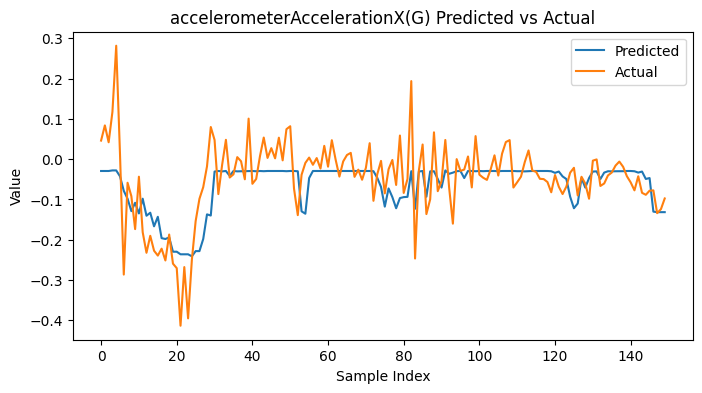

accelerometerAccelerationX(G) RMSE: 0.07557792794500202


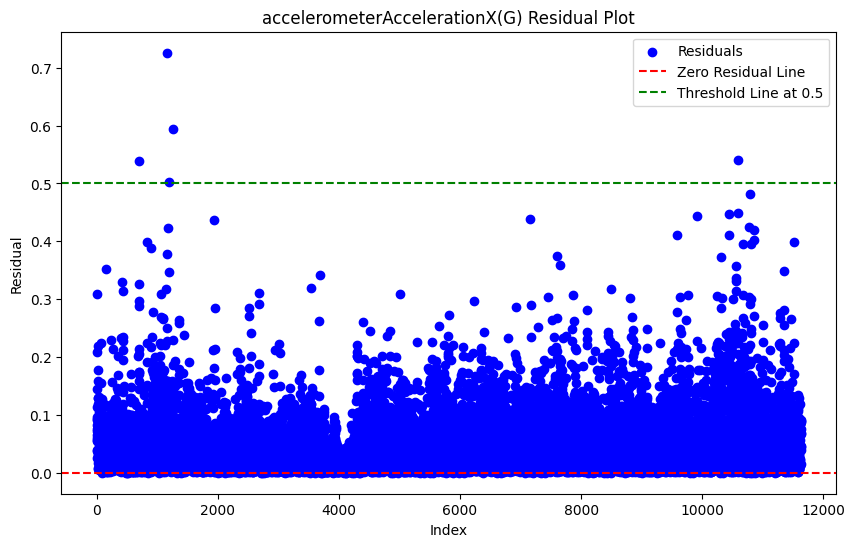

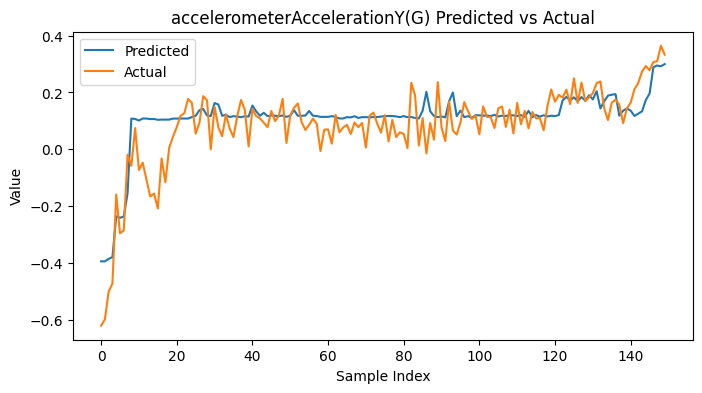

accelerometerAccelerationY(G) RMSE: 0.0945491438050376


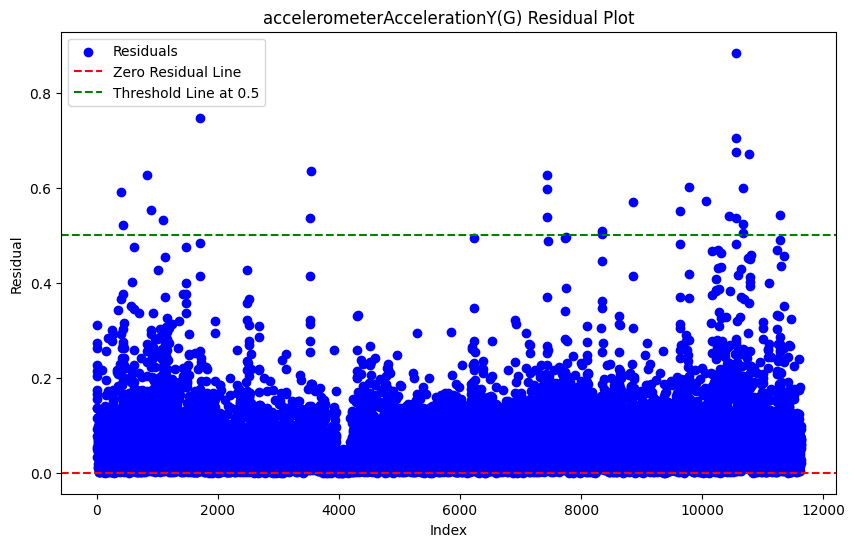

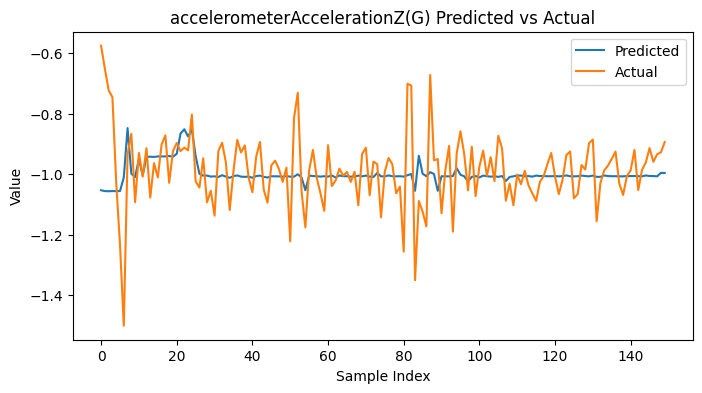

accelerometerAccelerationZ(G) RMSE: 0.14614391547254527


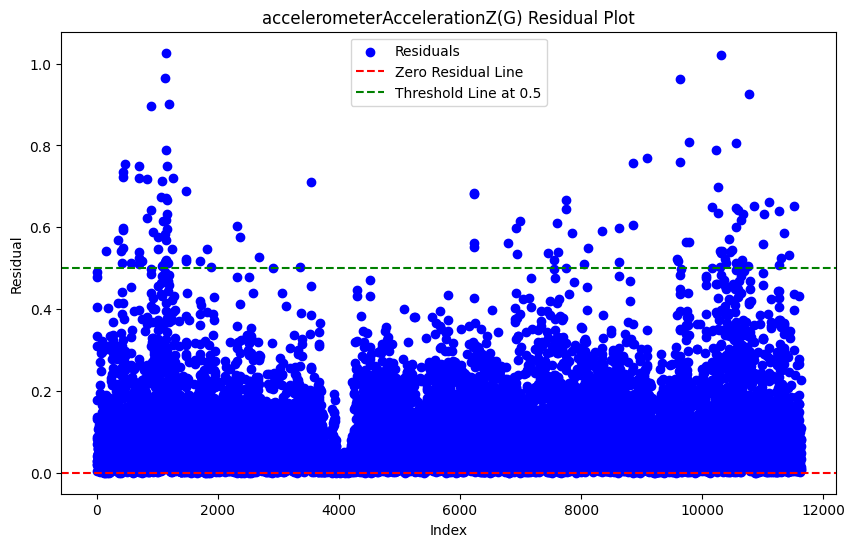

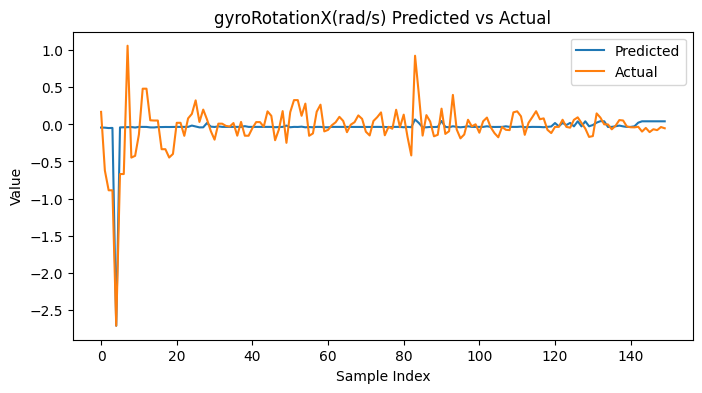

gyroRotationX(rad/s) RMSE: 0.2407713021729707


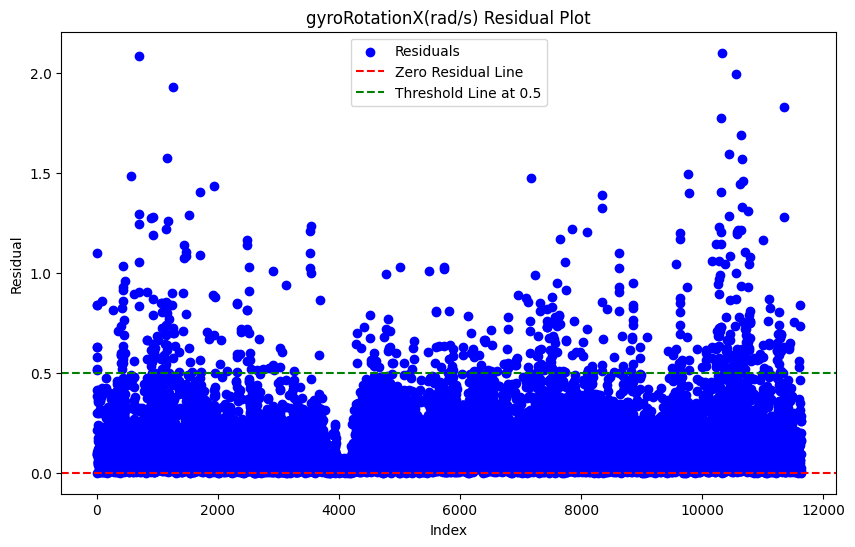

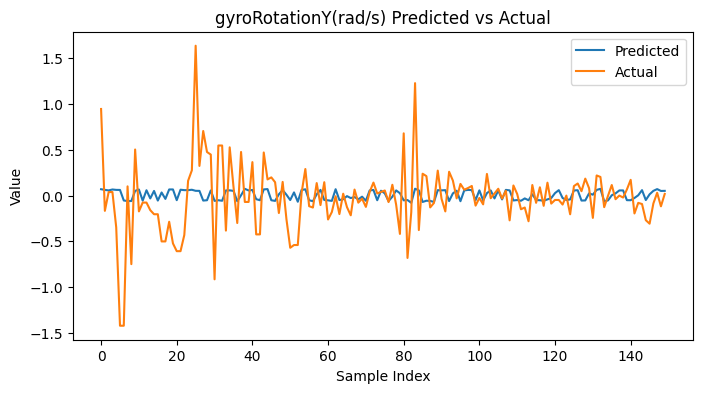

gyroRotationY(rad/s) RMSE: 0.34730421224790076


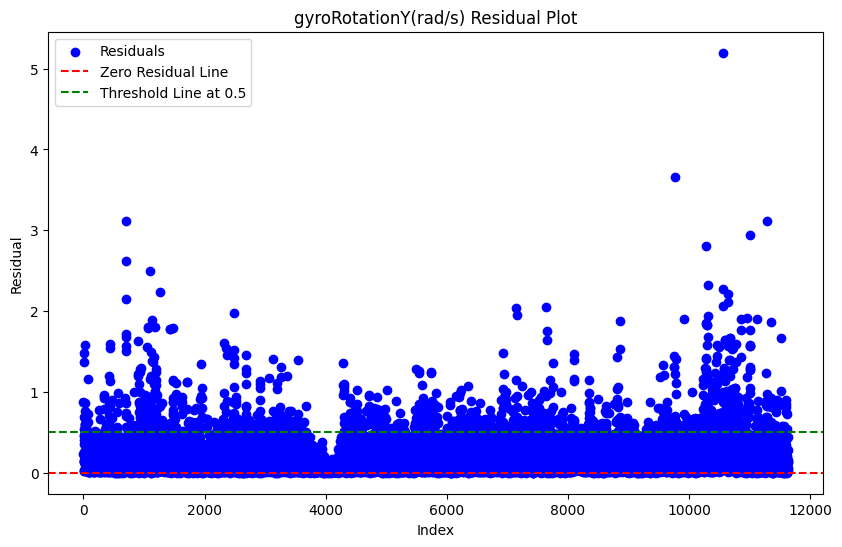

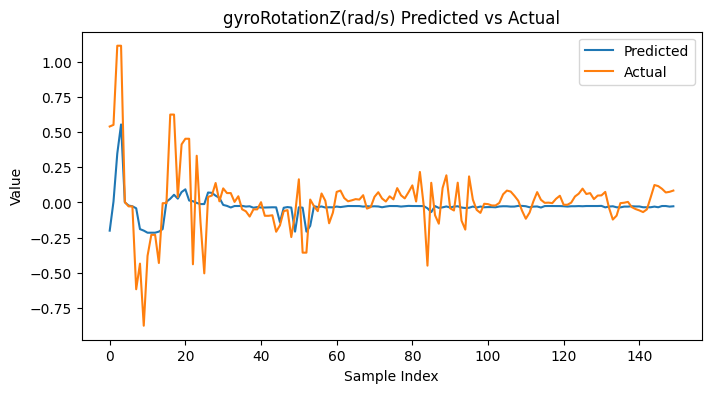

gyroRotationZ(rad/s) RMSE: 0.15190802839266196


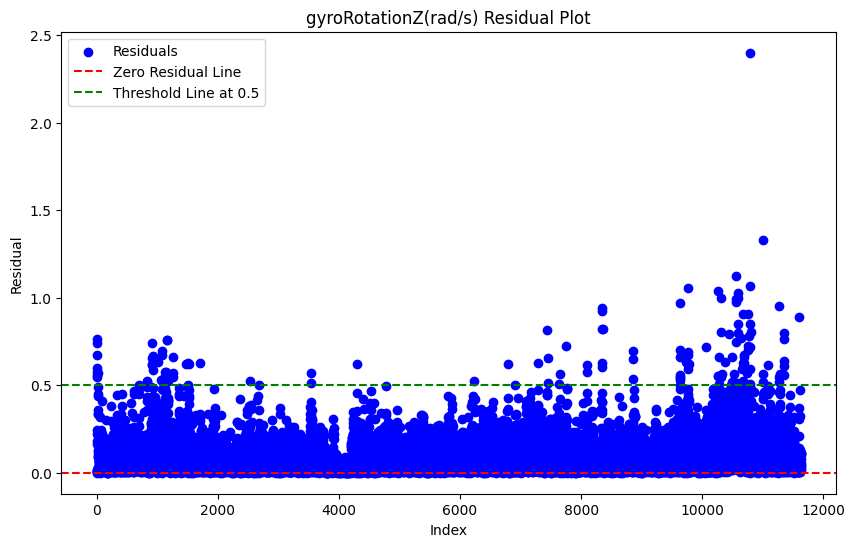

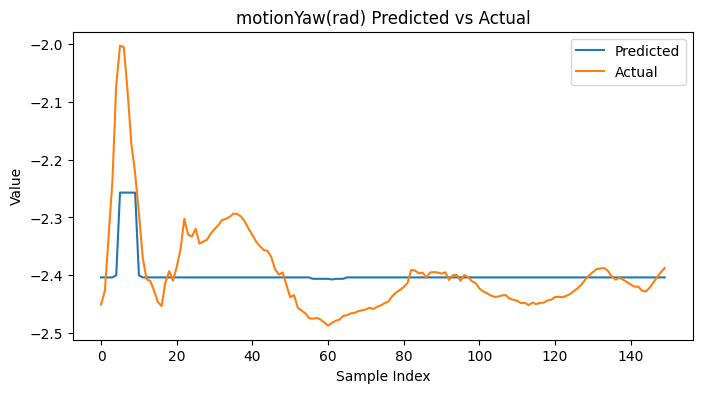

motionYaw(rad) RMSE: 0.23273794322005012


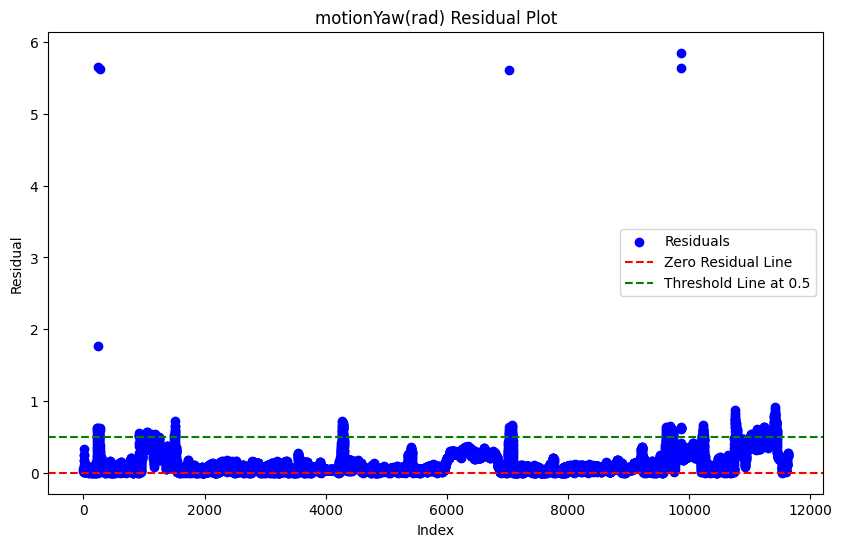

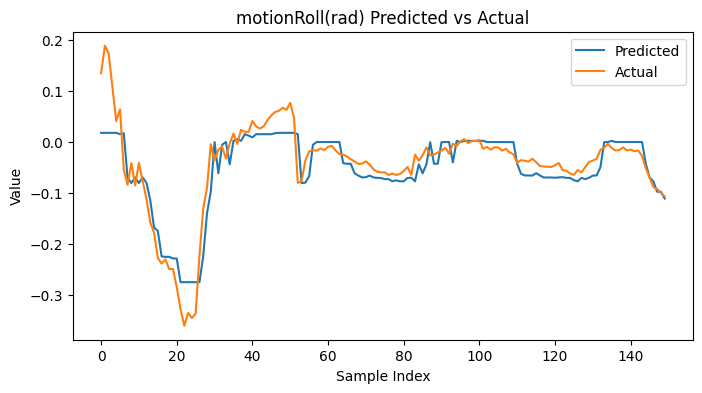

motionRoll(rad) RMSE: 0.024499729352304416


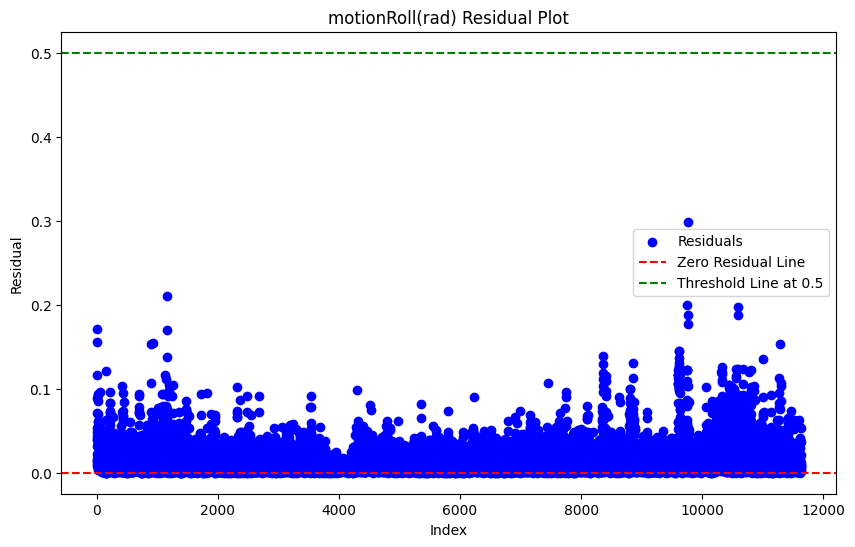

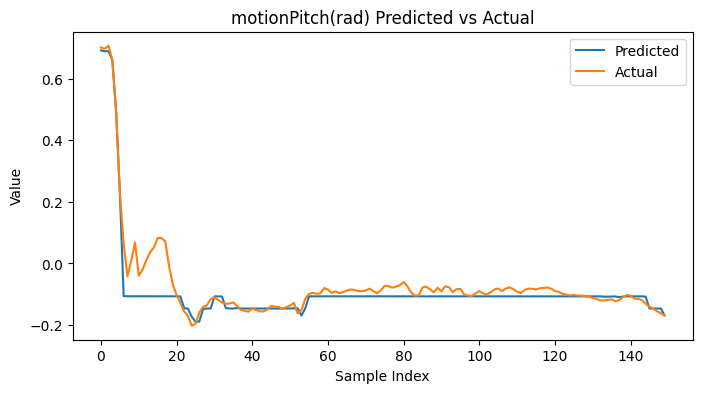

motionPitch(rad) RMSE: 0.020274473188638363


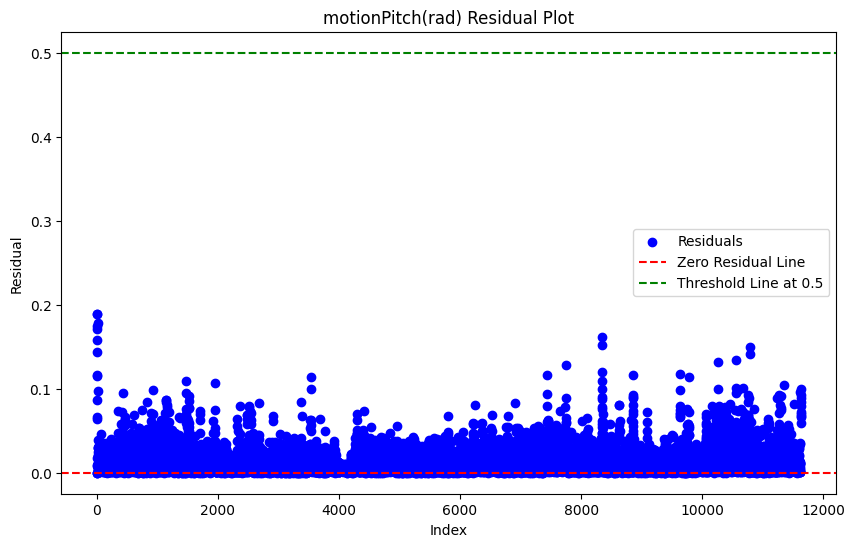

In [ ]:
# Assuming you have MinMaxScaler defined
scaler = MinMaxScaler()

# # Assuming X2 is your input data
# X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

X_scaled = X
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have the AdaBoostRegressor model named adaboost_model and X2
test_data_pred = np.column_stack([model.predict(X_scaled.reshape(X_scaled.shape[0], -1)) for model in adaboost_models])

# Define the number of outputs
num_outputs = test_data_pred.shape[1]

# Define output labels based on your dataset
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
           'gyroRotationX(rad/s)','gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
           'motionYaw(rad)','motionRoll(rad)','motionPitch(rad)']

# Visualize each output separately with corresponding labels
for i in range(num_outputs):
    # Create a DataFrame with predicted and actual values for the current output
    output_data = pd.DataFrame(data={'Predicted': test_data_pred[:, i], 'Actual': y[:, i]})

    # Plot predicted and actual values
    plt.figure(figsize=(8, 4))
    plt.plot(output_data['Predicted'][:150], label='Predicted')
    plt.plot(output_data['Actual'][:150], label='Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'{output_labels[i]} Predicted vs Actual')
    plt.legend()
    plt.show()

    # Calculate RMSE
    output_data['Residual'] = output_data['Predicted'] - output_data['Actual']
    output_data['RMSE'] = np.sqrt(np.square(output_data['Residual']))
    mse = (output_data['Residual'] ** 2).mean()
    rmse = np.sqrt(mse)
    print(f'{output_labels[i]} RMSE: {rmse}')

    # Plot Residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(output_data.index, output_data['RMSE'], color='blue', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold Line at 0.5')  # Threshold line at 0.5
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.title(f'{output_labels[i]} Residual Plot')
    plt.legend()
    plt.show()


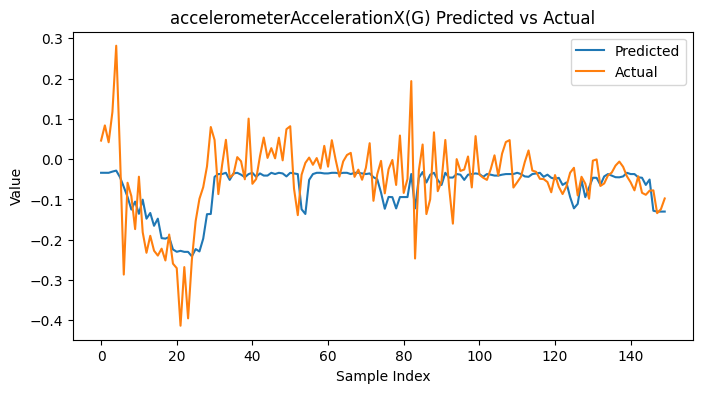

accelerometerAccelerationX(G) RMSE: 0.07551018359524257


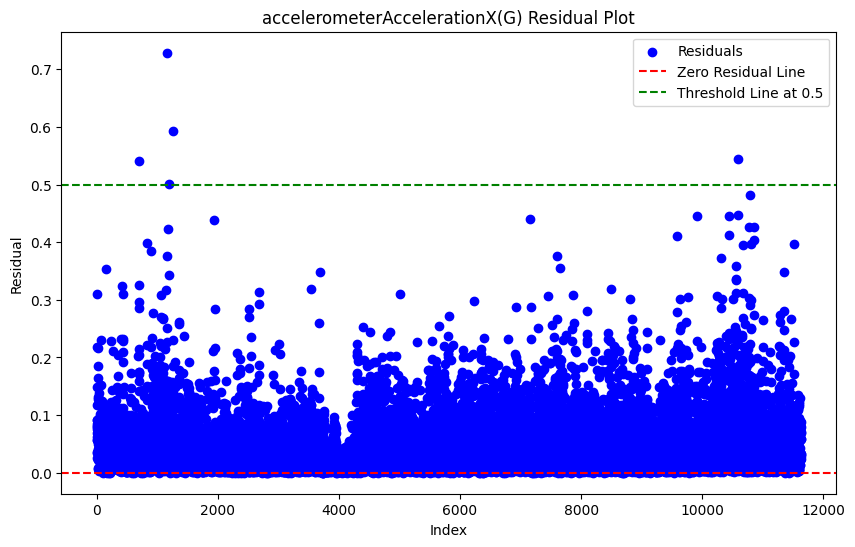

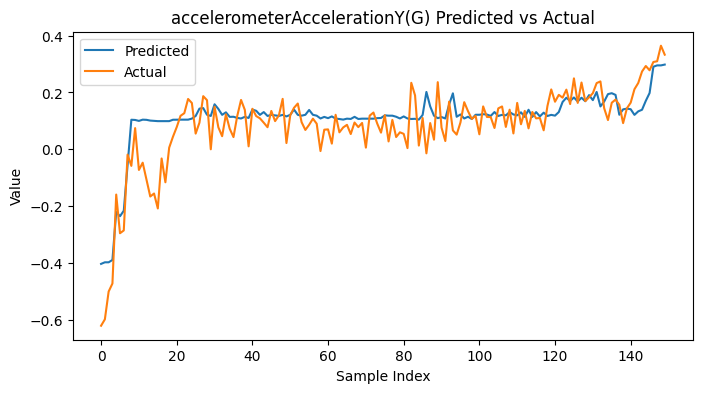

accelerometerAccelerationY(G) RMSE: 0.09437103975804433


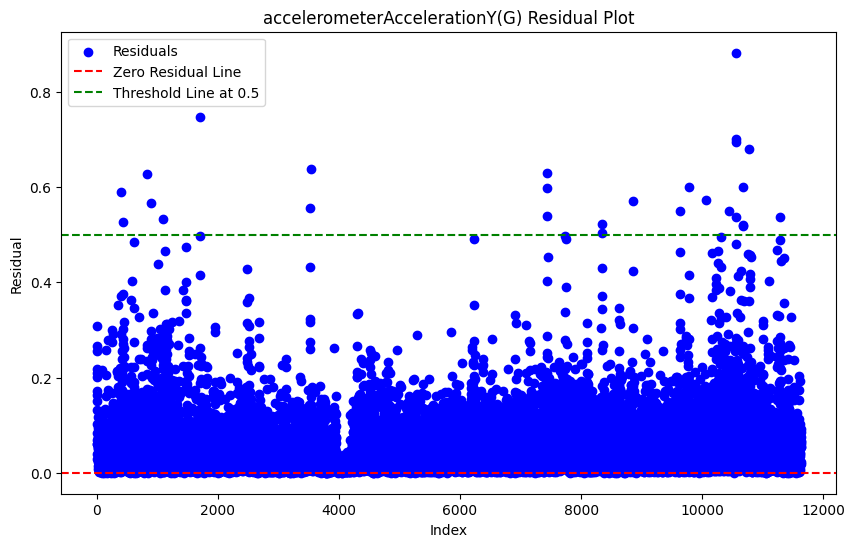

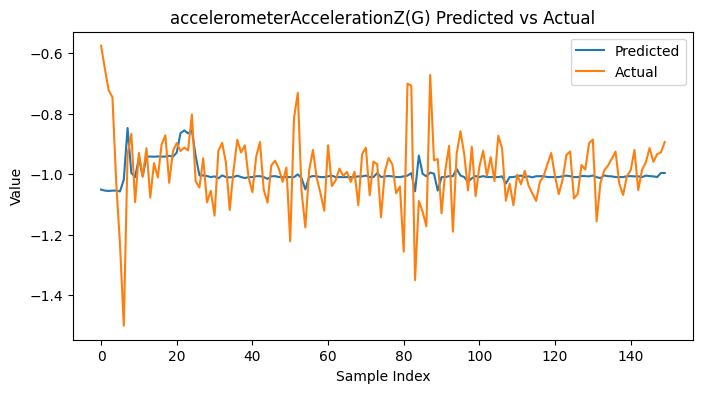

accelerometerAccelerationZ(G) RMSE: 0.14649661630051883


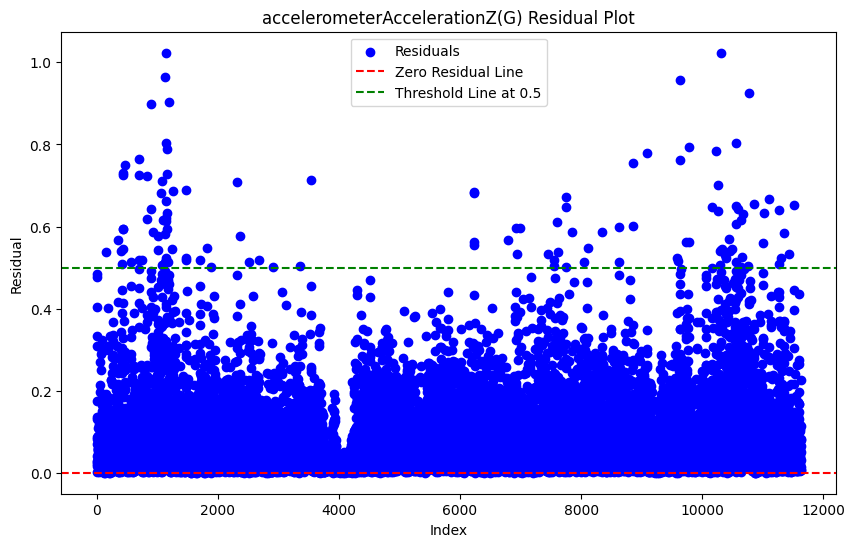

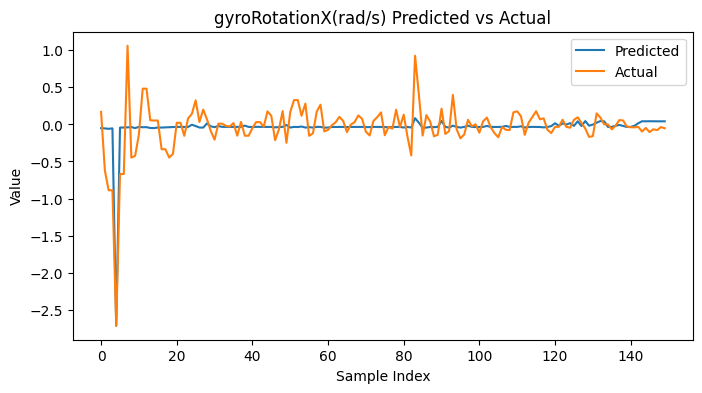

gyroRotationX(rad/s) RMSE: 0.2402354794508168


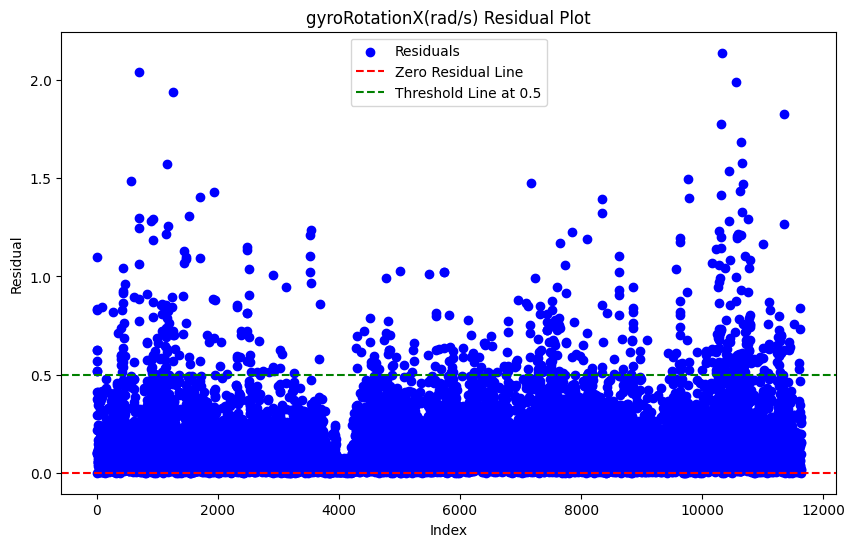

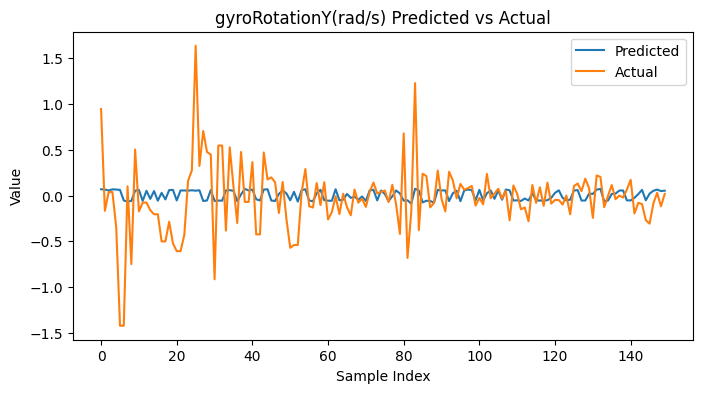

gyroRotationY(rad/s) RMSE: 0.3464602907939769


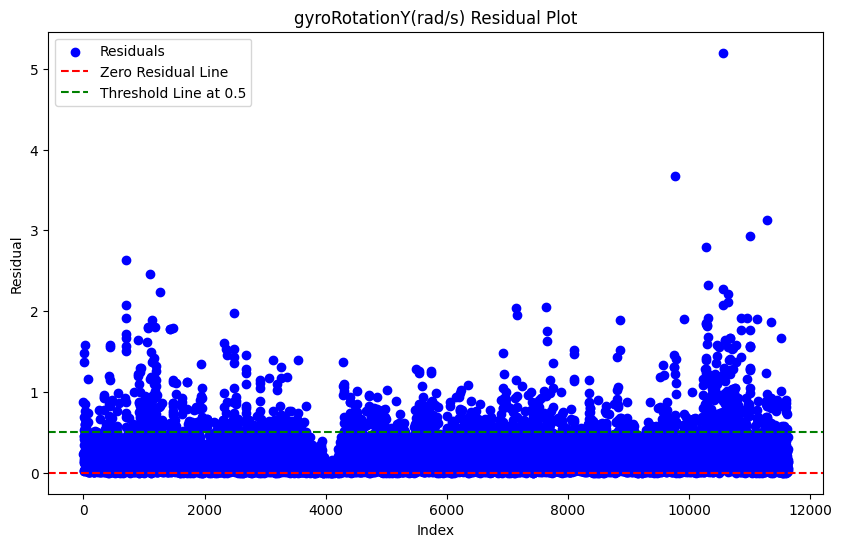

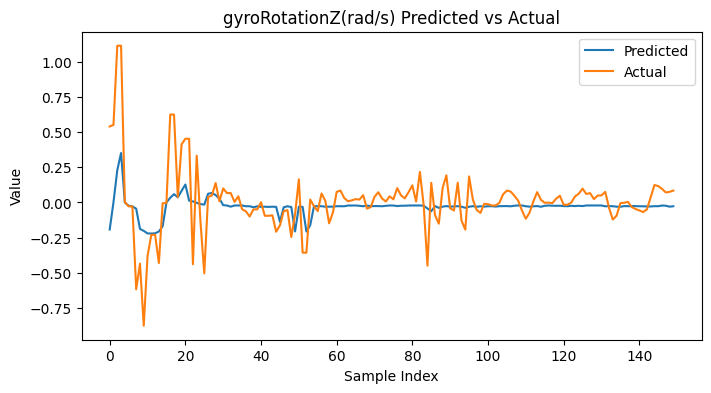

gyroRotationZ(rad/s) RMSE: 0.15225182126018375


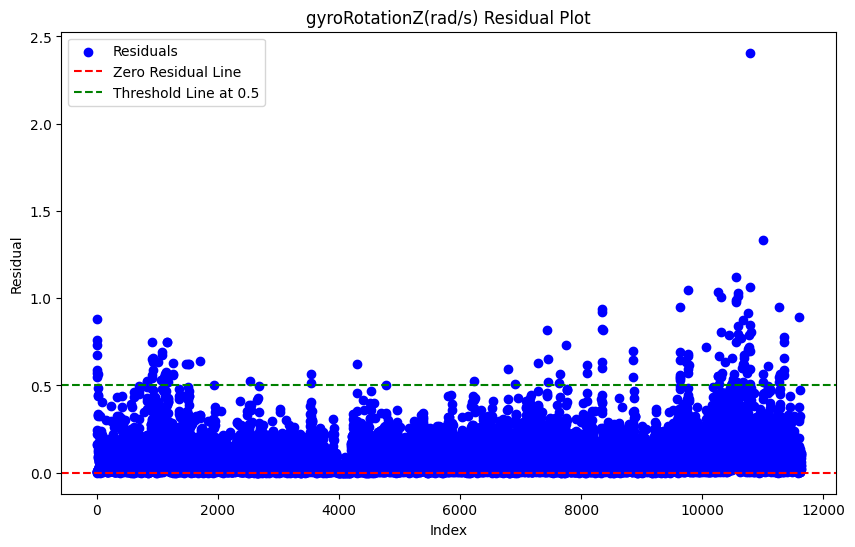

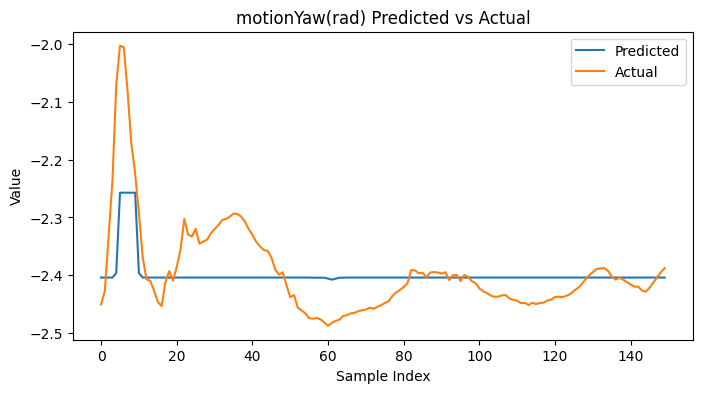

motionYaw(rad) RMSE: 0.23396644753621335


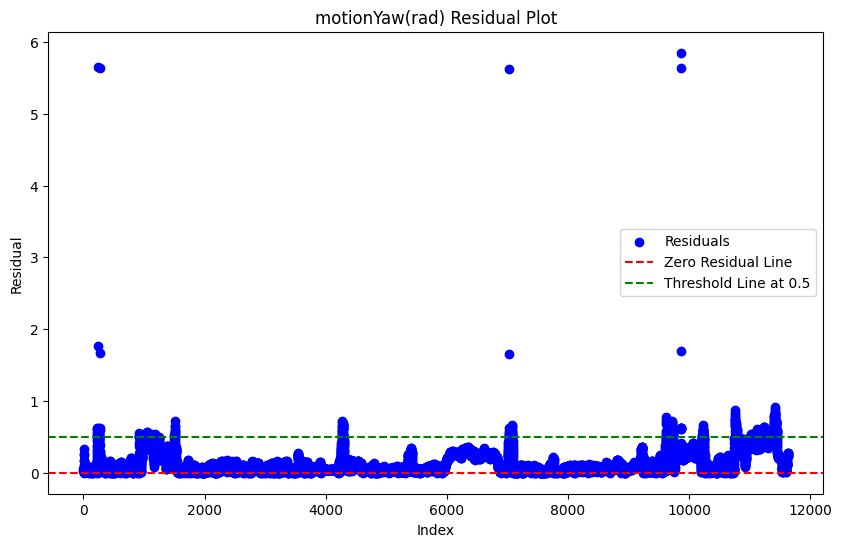

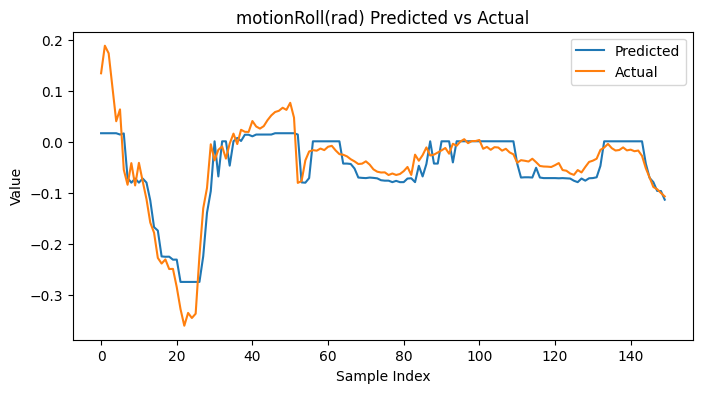

motionRoll(rad) RMSE: 0.024563696318038477


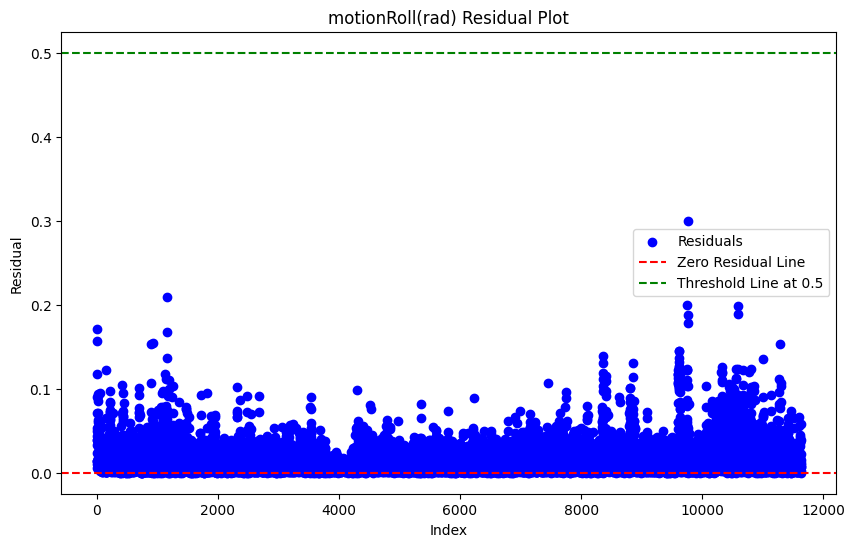

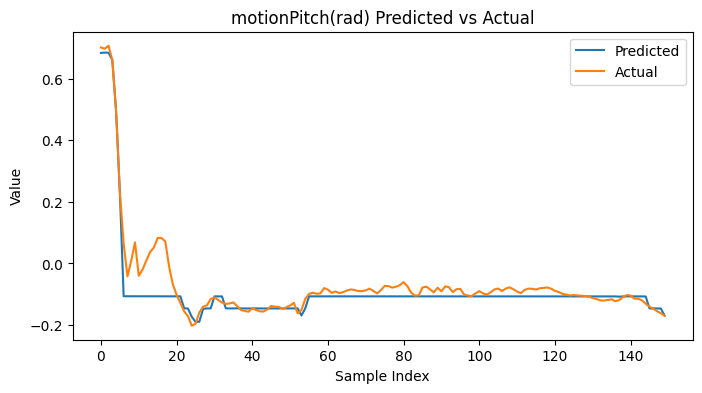

motionPitch(rad) RMSE: 0.020356142200711334


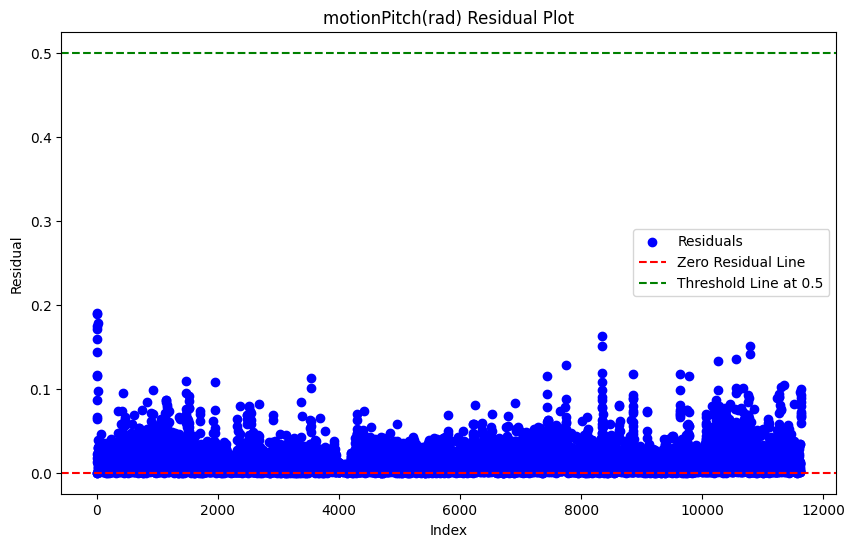

In [ ]:
# Assuming you have MinMaxScaler defined
scaler = MinMaxScaler()

# # Assuming X2 is your input data
# X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

X_scaled = X
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have the AdaBoostRegressor model named adaboost_model and X2
train_data_pred = np.column_stack([model.predict(X_scaled.reshape(X_scaled.shape[0], -1)) for model in adaboost_models])

# Define the number of outputs
num_outputs = train_data_pred.shape[1]

# Define output labels based on your dataset
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
           'gyroRotationX(rad/s)','gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
           'motionYaw(rad)','motionRoll(rad)','motionPitch(rad)']

# Visualize each output separately with corresponding labels
for i in range(num_outputs):
    # Create a DataFrame with predicted and actual values for the current output
    output_data = pd.DataFrame(data={'Predicted': test_data_pred[:, i], 'Actual': y[:, i]})

    # Plot predicted and actual values
    plt.figure(figsize=(8, 4))
    plt.plot(output_data['Predicted'][:150], label='Predicted')
    plt.plot(output_data['Actual'][:150], label='Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'{output_labels[i]} Predicted vs Actual')
    plt.legend()
    plt.show()

    # Calculate RMSE
    output_data['Residual'] = output_data['Predicted'] - output_data['Actual']
    output_data['RMSE'] = np.sqrt(np.square(output_data['Residual']))
    mse = (output_data['Residual'] ** 2).mean()
    rmse = np.sqrt(mse)
    print(f'{output_labels[i]} RMSE: {rmse}')

    # Plot Residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(output_data.index, output_data['RMSE'], color='blue', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold Line at 0.5')  # Threshold line at 0.5
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.title(f'{output_labels[i]} Residual Plot')
    plt.legend()
    plt.show()


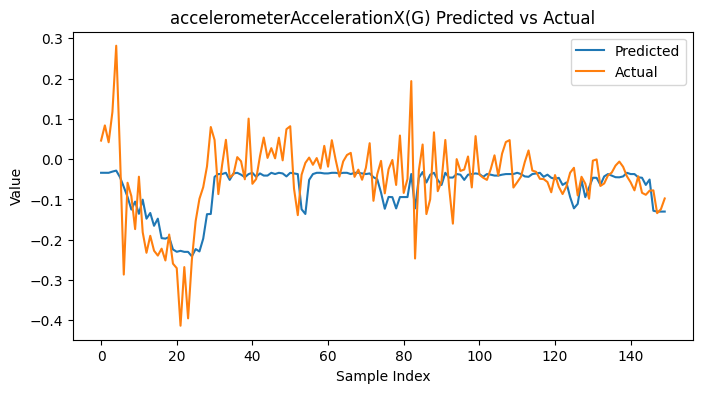

accelerometerAccelerationX(G) RMSE: 0.07551018359524257


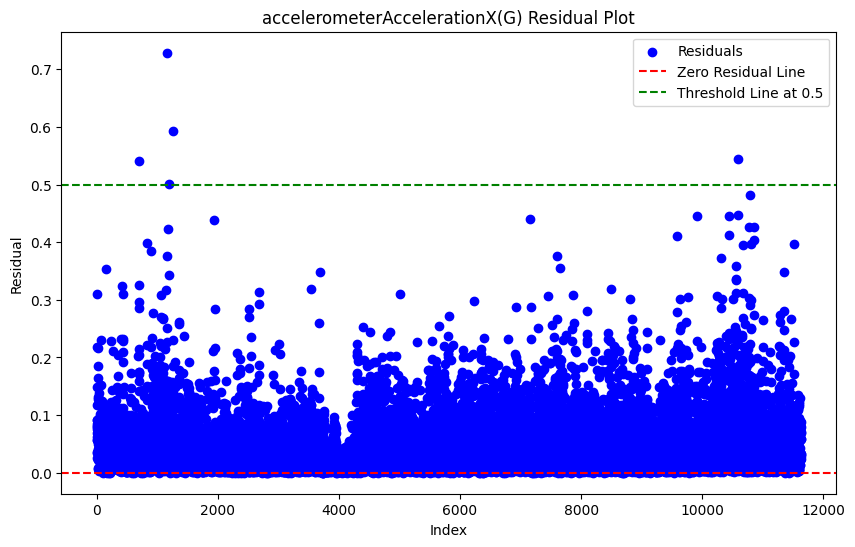

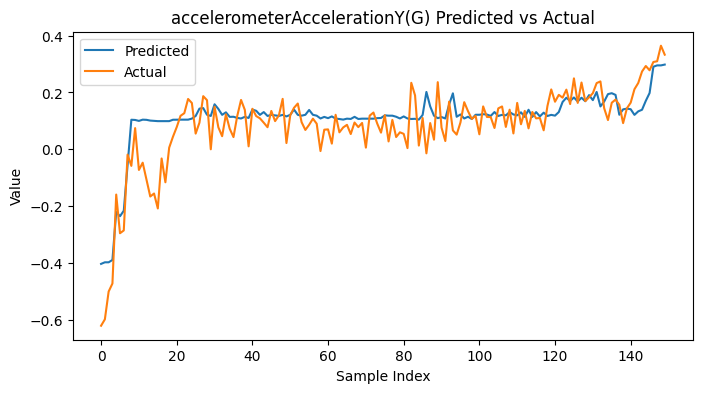

accelerometerAccelerationY(G) RMSE: 0.09437103975804433


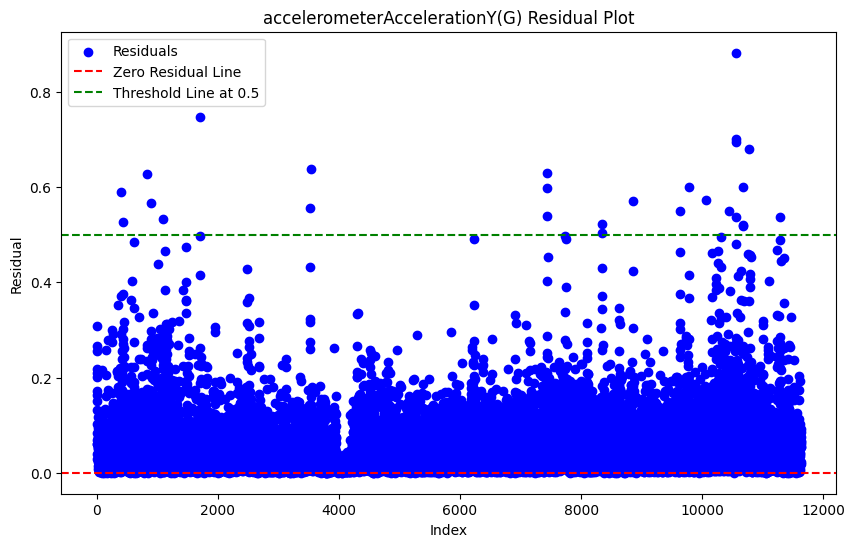

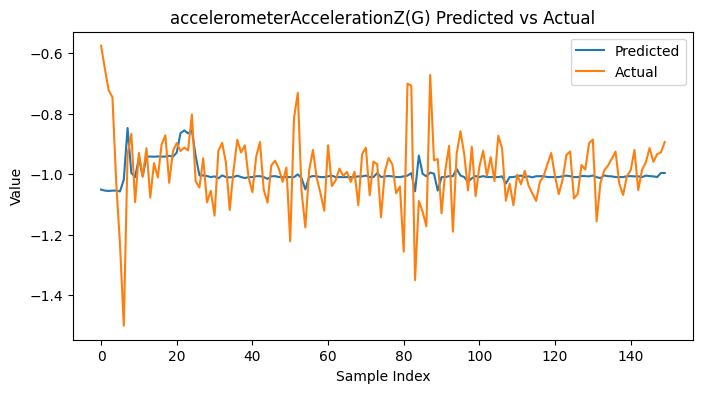

accelerometerAccelerationZ(G) RMSE: 0.14649661630051883


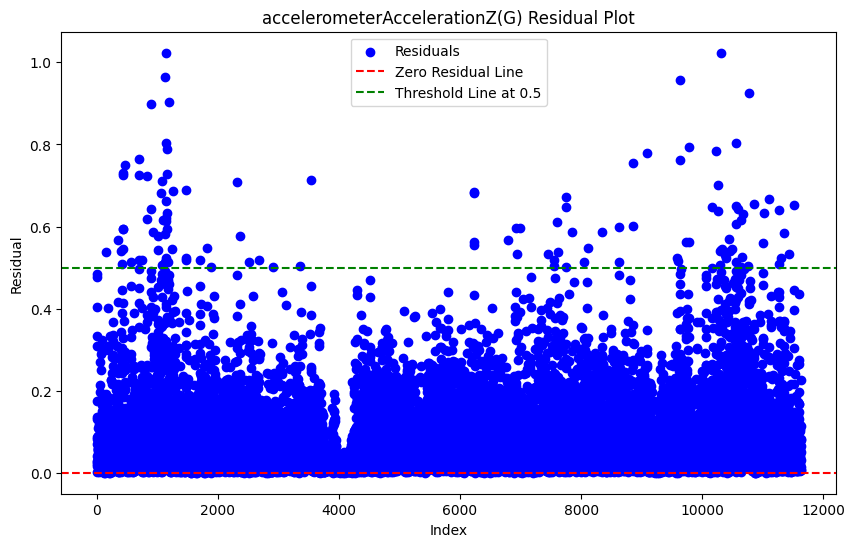

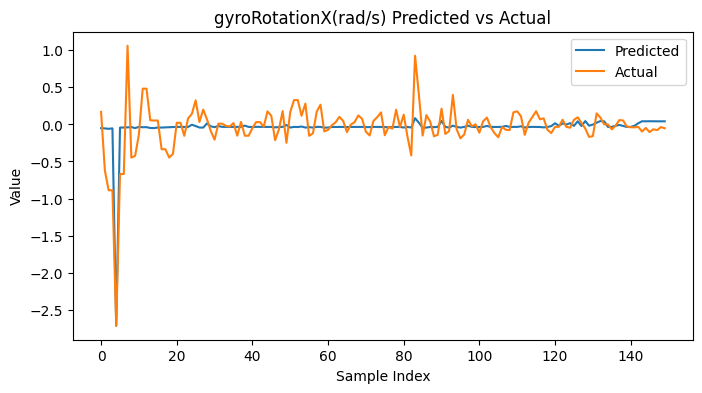

gyroRotationX(rad/s) RMSE: 0.2402354794508168


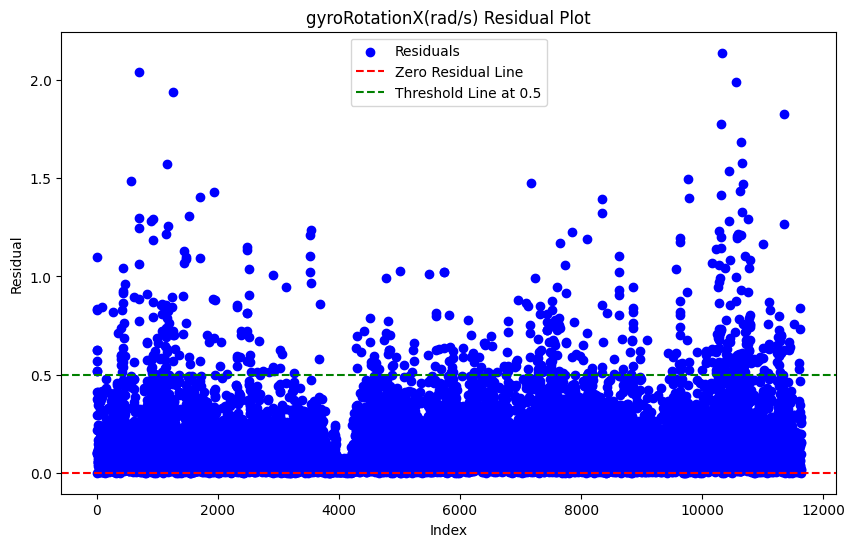

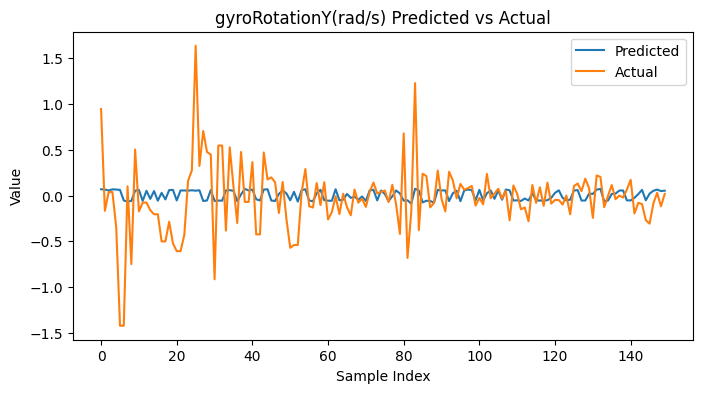

gyroRotationY(rad/s) RMSE: 0.3464602907939769


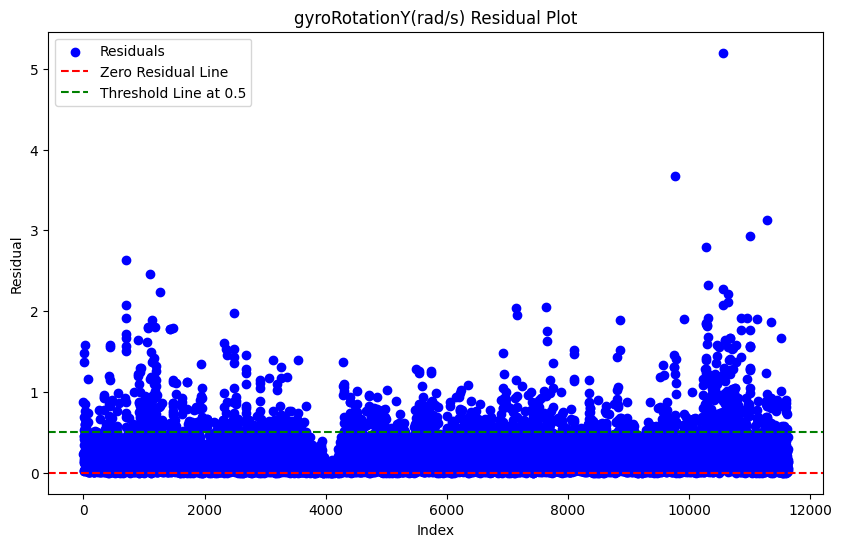

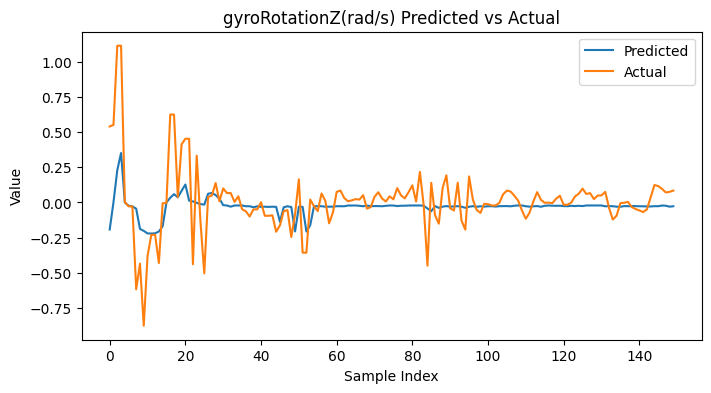

gyroRotationZ(rad/s) RMSE: 0.15225182126018375


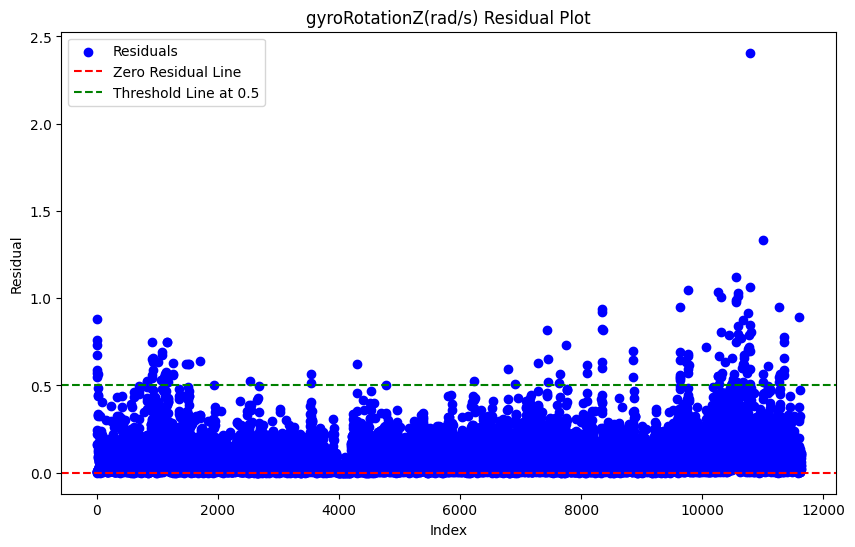

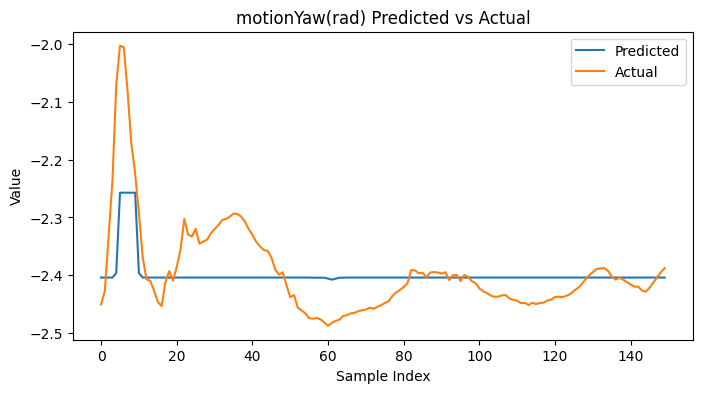

motionYaw(rad) RMSE: 0.23396644753621335


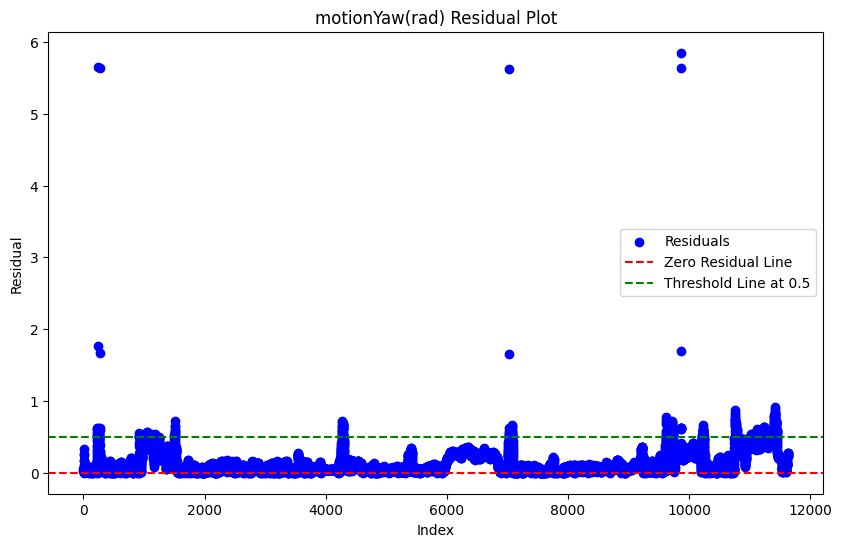

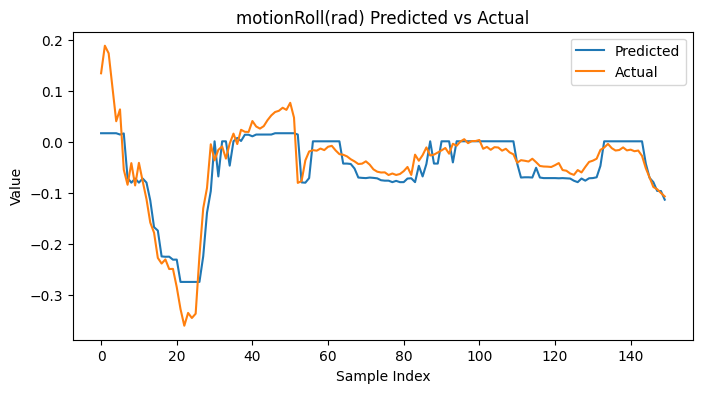

motionRoll(rad) RMSE: 0.024563696318038477


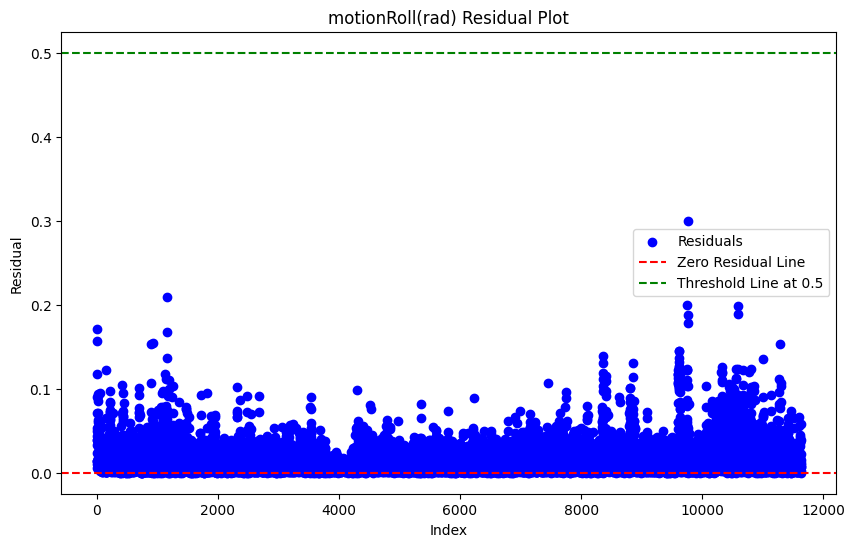

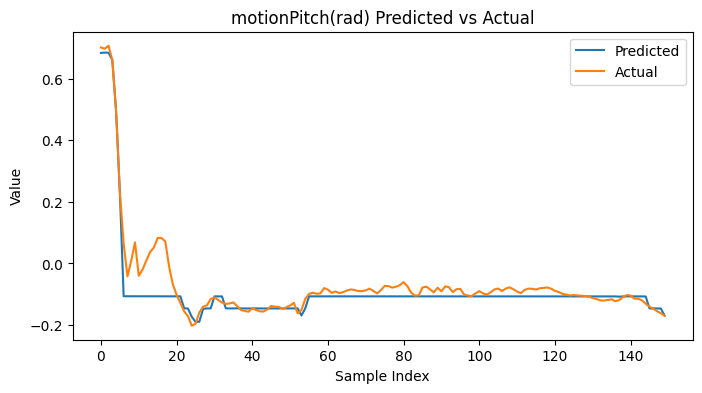

motionPitch(rad) RMSE: 0.020356142200711334


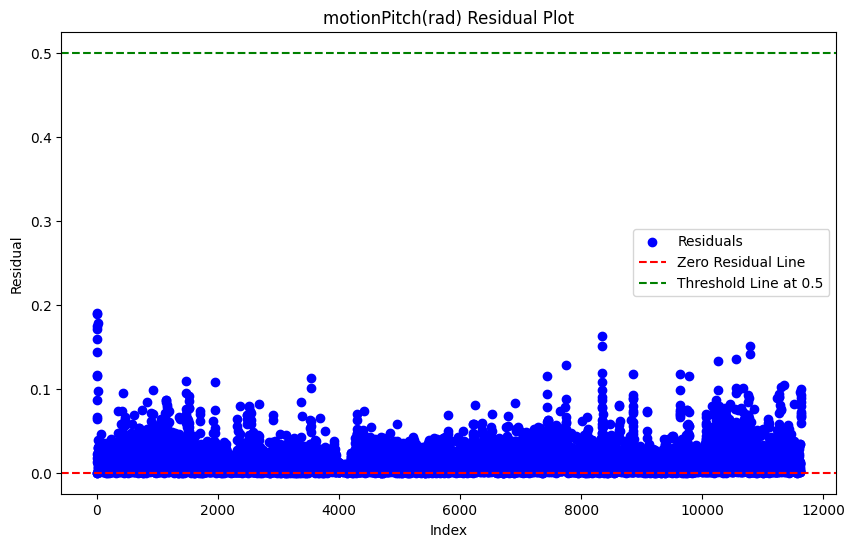

In [ ]:
# Assuming you have MinMaxScaler defined
scaler = MinMaxScaler()

# # Assuming X2 is your input data
# X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

X_scaled = X
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming you have the AdaBoostRegressor model named adaboost_model and X2
test_data_pred = np.column_stack([model.predict(X_scaled.reshape(X_scaled.shape[0], -1)) for model in adaboost_models])

# Define the number of outputs
num_outputs = test_data_pred.shape[1]

# Define output labels based on your dataset
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
           'gyroRotationX(rad/s)','gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
           'motionYaw(rad)','motionRoll(rad)','motionPitch(rad)']

# Visualize each output separately with corresponding labels
for i in range(num_outputs):
    # Create a DataFrame with predicted and actual values for the current output
    output_data = pd.DataFrame(data={'Predicted': test_data_pred[:, i], 'Actual': y[:, i]})

    # Plot predicted and actual values
    plt.figure(figsize=(8, 4))
    plt.plot(output_data['Predicted'][:150], label='Predicted')
    plt.plot(output_data['Actual'][:150], label='Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'{output_labels[i]} Predicted vs Actual')
    plt.legend()
    plt.show()

    # Calculate RMSE
    output_data['Residual'] = output_data['Predicted'] - output_data['Actual']
    output_data['RMSE'] = np.sqrt(np.square(output_data['Residual']))
    mse = (output_data['Residual'] ** 2).mean()
    rmse = np.sqrt(mse)
    print(f'{output_labels[i]} RMSE: {rmse}')

    # Plot Residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(output_data.index, output_data['RMSE'], color='blue', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold Line at 0.5')  # Threshold line at 0.5
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.title(f'{output_labels[i]} Residual Plot')
    plt.legend()
    plt.show()


In [ ]:
# # Plot loss over epochs
# plt.plot(history.loss_curve_)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss over Epochs')
# plt.show()


# **Testing**

In [ ]:
# Load and preprocess the test data
df2 = pd.read_csv('/content/drive/MyDrive/LSTM/modified_latest_finalday32.csv')
#df2['loggingTime(txt)'] = df2['loggingTime(txt)'].dt.tz_localize(None)
#df2.set_index('loggingTime(txt)', inplace=True)
data2 = df2[['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
            'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
            'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']]

In [ ]:
df2.shape

(8215, 10)

In [ ]:
# Assuming you have a function df_to_X_y defined for converting DataFrame to X and y
WINDOW_SIZE = 8
X2, y2 = df_to_X_y(data2, WINDOW_SIZE)

In [ ]:

# # Scale the test data using the same scaler used for training data
# X2_scaled = scaler.transform(X2.reshape(-1, X2.shape[-1])).reshape(X2.shape)
X2_scaled = X2

In [ ]:
# Predict using the trained AdaBoostRegressor models
test_data_pred2 = np.column_stack([model.predict(X2_scaled.reshape(X2_scaled.shape[0], -1)) for model in adaboost_models])


In [ ]:
y2.shape

(8207, 9)

In [ ]:
test_data_pred2.shape

(8207, 9)

In [ ]:
import numpy as np

residual_values = np.zeros((y2.shape[0],))

for i in range(y2.shape[0]):
    vector_magnitude_test_predictions = np.linalg.norm(test_data_pred2[i, :])
    vector_magnitude_y_test = np.linalg.norm(y2[i, :])

    residual_values[i] = vector_magnitude_test_predictions - vector_magnitude_y_test

print(residual_values)

[ 1.32864584 -0.35130555 -0.35170106 ... -0.02814923 -0.48029739
 -0.24206712]


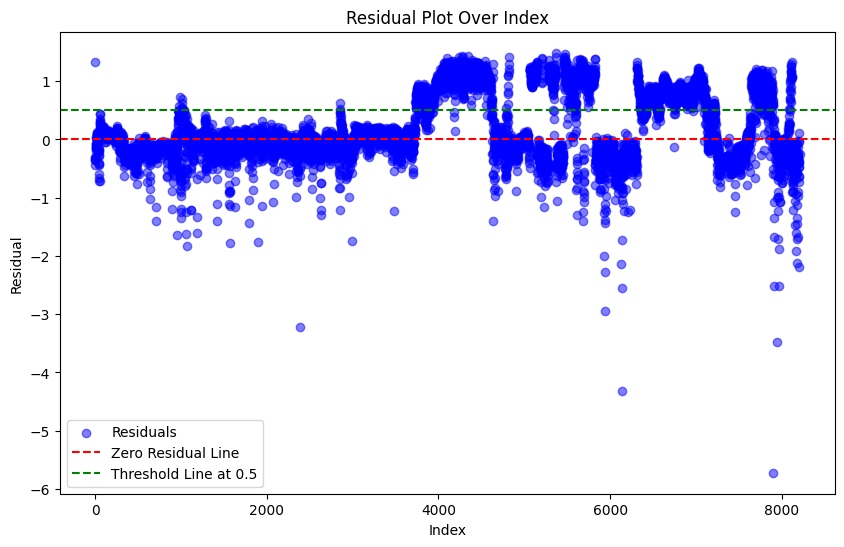

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Scatter plot of residuals against index
plt.scatter(np.arange(len(residual_values)), residual_values, color='blue', label='Residuals', alpha=0.5)

# Horizontal lines
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold Line at 0.5')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot Over Index')

# Legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
test_data_pred2[0:16]

array([[-1.32064243e-01,  1.10804629e-01, -9.84651118e-01,
        -3.50164515e-02,  5.35973554e-02, -2.12571118e-01,
         1.24036150e+00, -7.83857331e-02, -1.46440308e-01],
       [-1.15719604e-01,  1.09798182e-01, -1.00910868e+00,
        -3.16422011e-02,  1.47634604e-02, -3.38549399e-02,
         1.24036150e+00, -7.70871864e-02, -1.46440308e-01],
       [-1.34279530e-01,  1.08247510e-01, -9.94015133e-01,
        -3.07542337e-02, -4.86114255e-02, -2.12189863e-01,
         1.24036150e+00, -1.07803201e-01, -1.46066280e-01],
       [-1.23059121e-01,  1.09193832e-01, -9.94836335e-01,
        -2.10019562e-02,  5.09122367e-02, -2.06598172e-01,
         1.24036150e+00, -9.69247632e-02, -1.46156848e-01],
       [-1.31481134e-01,  1.17912581e-01, -9.54913714e-01,
         1.69466150e-02,  5.27758102e-04, -2.12571118e-01,
         1.24036150e+00, -1.11447071e-01, -1.46440308e-01],
       [-1.63749967e-01,  1.40120309e-01, -9.46611481e-01,
         6.04748270e-02,  4.79034411e-02, -2.130547

In [ ]:
y2[0:16]

array([[-0.00668335,  0.09684753, -1.03147888, -0.02387737,  0.31198853,
        -0.14215128,  1.06254338, -0.0694033 , -0.14814219],
       [-0.11366272,  0.1348114 , -0.92788696,  0.0156783 , -0.05932644,
        -0.49834427,  1.04962032, -0.0960394 , -0.13703422],
       [-0.13288879,  0.17430115, -0.984375  , -0.13914084,  0.12690549,
        -0.46325606,  1.00044901, -0.08705304, -0.14329388],
       [-0.17169189,  0.20144653, -0.96034241, -0.40411204, -0.20867518,
        -0.29239538,  0.95161487, -0.09768734, -0.15212519],
       [-0.18153381,  0.24949646, -1.08610535,  0.09030513,  0.23939422,
        -0.4857153 ,  0.90986775, -0.11413959, -0.18386257],
       [-0.13244629,  0.20744324, -0.93292236,  0.09030513,  0.23939422,
        -0.4857153 ,  0.8672633 , -0.10145533, -0.17096792],
       [-0.03910828,  0.18730164, -1.06680298,  0.0554313 ,  0.05296282,
        -0.50864887,  0.82025498, -0.09404727, -0.17414594],
       [-0.0637207 ,  0.16783142, -0.91001892, -0.08618176,  0

In [ ]:
absolute_residual_values = np.abs(residual_values)

In [ ]:
df2[['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
            'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
            'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']].head(15)

accelerometerAccelerationX(G)  accelerometerAccelerationY(G)  \
0                       -0.062164                       0.087219   
1                        0.010422                       0.071045   
2                       -0.133179                       0.120468   
3                       -0.051407                       0.095810   
4                       -0.040253                       0.073471   
5                       -0.111450                       0.008636   
6                       -0.052109                       0.100220   
7                       -0.157562                      -0.049271   
8                       -0.006683                       0.096848   
9                       -0.113663                       0.134811   
10                      -0.132889                       0.174301   
11                      -0.171692                       0.201447   
12                      -0.181534                       0.249496   
13                      -0.132446                       0.207443   
14                      -0.039108                       0.187302   

    accelerometerAccelerationZ(G)  gyroRotationX(rad/s)  gyroRotationY(rad/s)  \
0                       -1.028366              0.016439              0.341306   
1                       -1.010254             -0.004868             -0.057749   
2                       -0.940887              0.028345              0.091572   
3                       -1.033401              0.018712              0.173653   
4                       -0.996536              0.018712              0.173653   
5                       -0.981934              0.046490              0.241693   
6                       -0.909195             -0.034777              0.040627   
7                       -0.972214              0.001542              0.172665   
8                       -1.031479             -0.023877              0.311989   
9                       -0.927887              0.015678             -0.059326   
10                      -0.984375             -0.139141              0.126905   
11                      -0.960342             -0.404112             -0.208675   
12                      -1.086105              0.090305              0.239394   
13                      -0.932922              0.090305              0.239394   
14                      -1.066803              0.055431              0.052963   

    gyroRotationZ(rad/s)  motionYaw(rad)  motionRoll(rad)  motionPitch(rad)  
0              -0.025112        1.264676        -0.098617         -0.171408  
1              -0.063348        1.264410        -0.089733         -0.163690  
2              -0.209158        1.263523        -0.071438         -0.162966  
3              -0.310739        1.250737        -0.074949         -0.161519  
4              -0.310739        1.227406        -0.072336         -0.153861  
5              -0.447101        1.177861        -0.077869         -0.150067  
6              -0.303045        1.128989        -0.065116         -0.147113  
7              -0.347554        1.096115        -0.077828         -0.150296  
8              -0.142151        1.062543        -0.069403         -0.148142  
9              -0.498344        1.049620        -0.096039         -0.137034  
10             -0.463256        1.000449        -0.087053         -0.143294  
11             -0.292395        0.951615        -0.097687         -0.152125  
12             -0.485715        0.909868        -0.114140         -0.183863  
13             -0.485715        0.867263        -0.101455         -0.170968  
14             -0.508649        0.820255        -0.094047         -0.174146

In [ ]:
absolute_residual_values[0:16]

array([1.32864584, 0.35130555, 0.35170106, 0.32595076, 0.44330266,
       0.2924669 , 0.29536013, 0.1336461 , 0.13771268, 0.15343132,
       0.19007834, 0.16581071, 0.11083727, 0.08020564, 0.06153746,
       0.03246632])

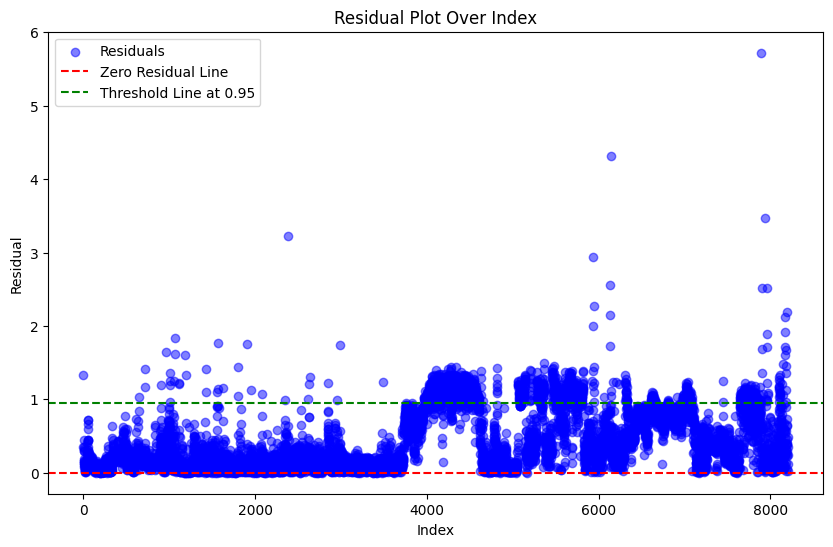

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Scatter plot of residuals against index
plt.scatter(np.arange(len(absolute_residual_values)), absolute_residual_values, color='blue', label='Residuals', alpha=0.5)

# Horizontal lines
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.axhline(y=0.95, color='green', linestyle='--', label='Threshold Line at 0.95')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot Over Index')

# Legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
absolute_residual_values.shape

(8207,)

In [ ]:

# Define the number of outputs
num_outputs = test_data_pred2.shape[1]

In [ ]:
# Assuming 'threshold' is the chosen threshold for anomalies
threshold = 1.1
anomaly_indicator = ((absolute_residual_values > threshold) & df2['label(N)'].isin([1,2])).astype(int)
print(anomaly_indicator)

In [ ]:
# Define output labels based on your dataset
output_labels = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)',
           'gyroRotationX(rad/s)', 'gyroRotationY(rad/s)', 'gyroRotationZ(rad/s)',
           'motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']

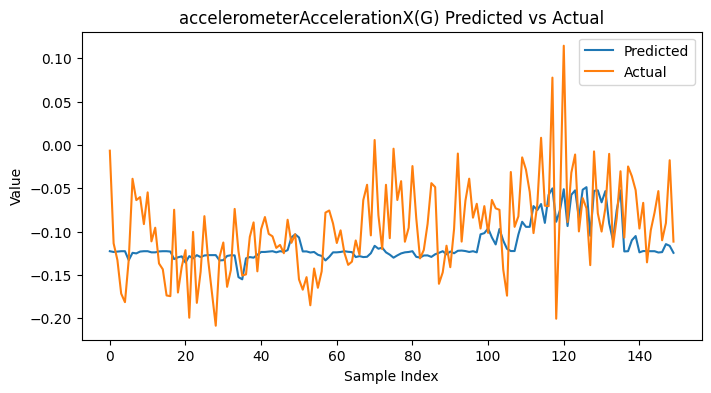

accelerometerAccelerationX(G) RMSE: 0.02537312847043487


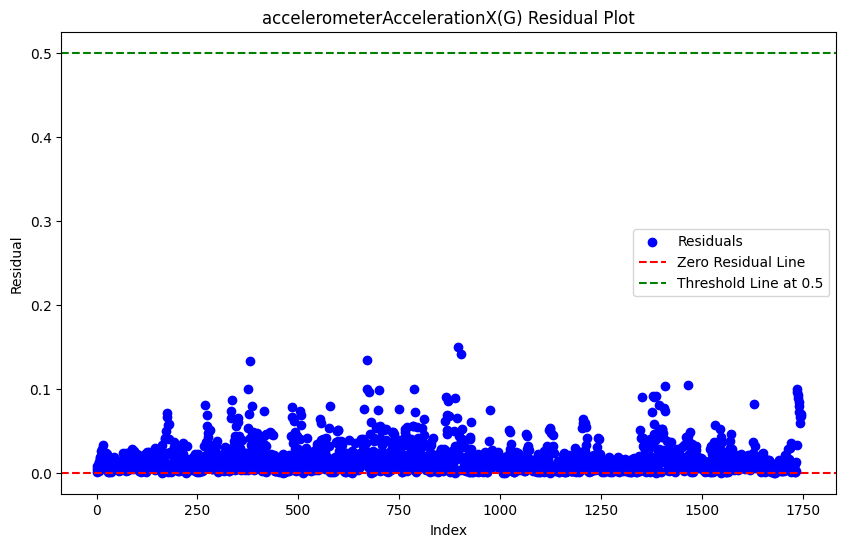

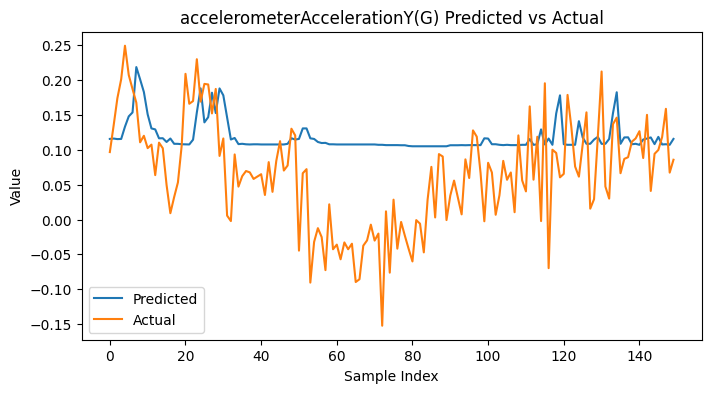

accelerometerAccelerationY(G) RMSE: 0.02537312847043487


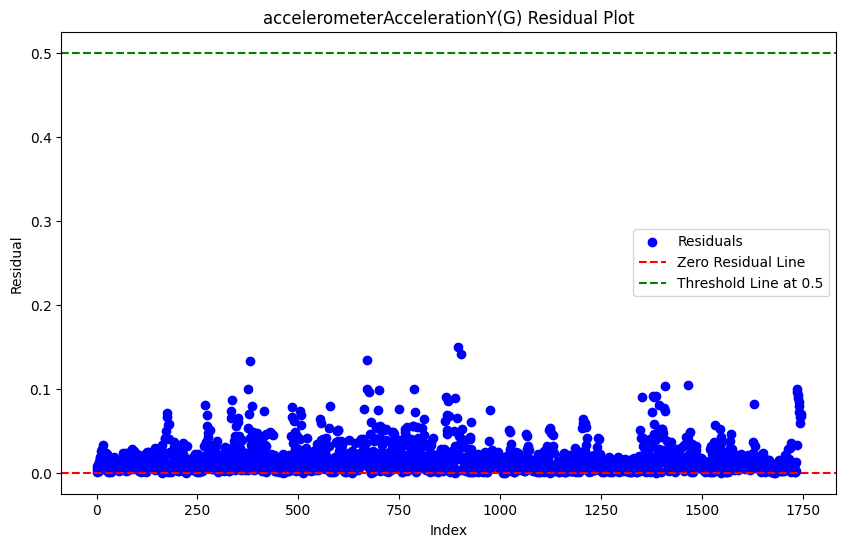

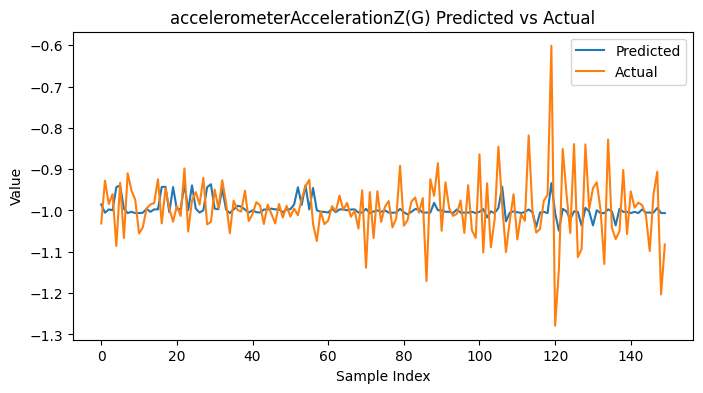

accelerometerAccelerationZ(G) RMSE: 0.02537312847043487


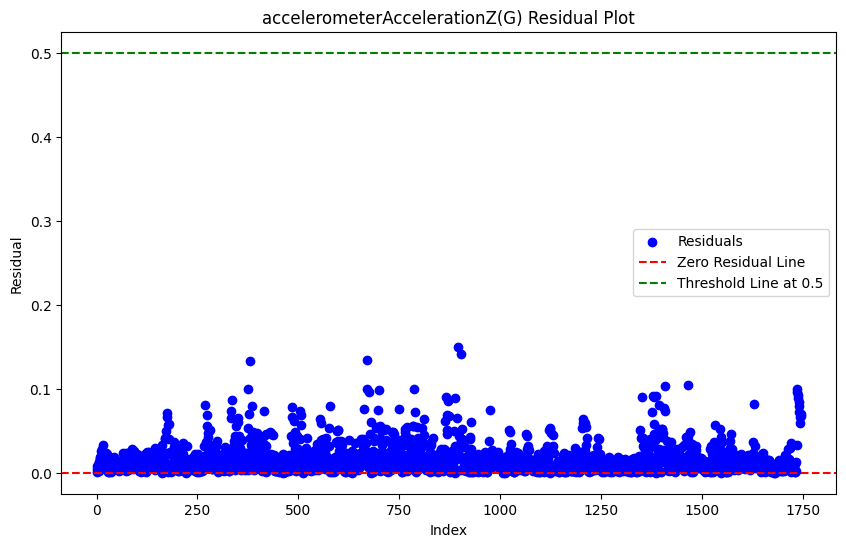

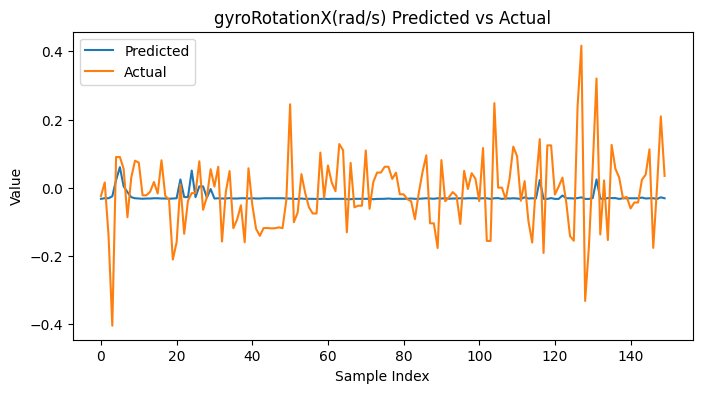

gyroRotationX(rad/s) RMSE: 0.02537312847043487


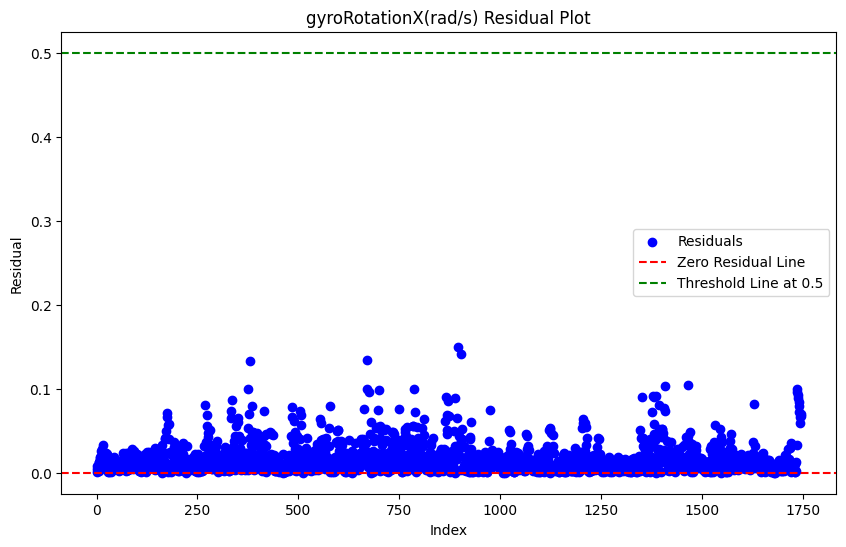

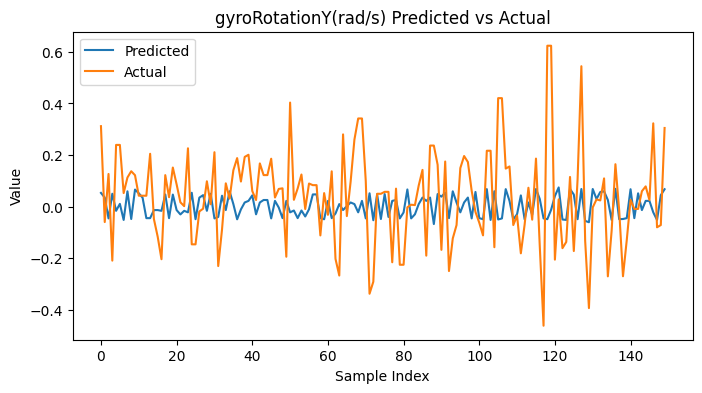

gyroRotationY(rad/s) RMSE: 0.02537312847043487


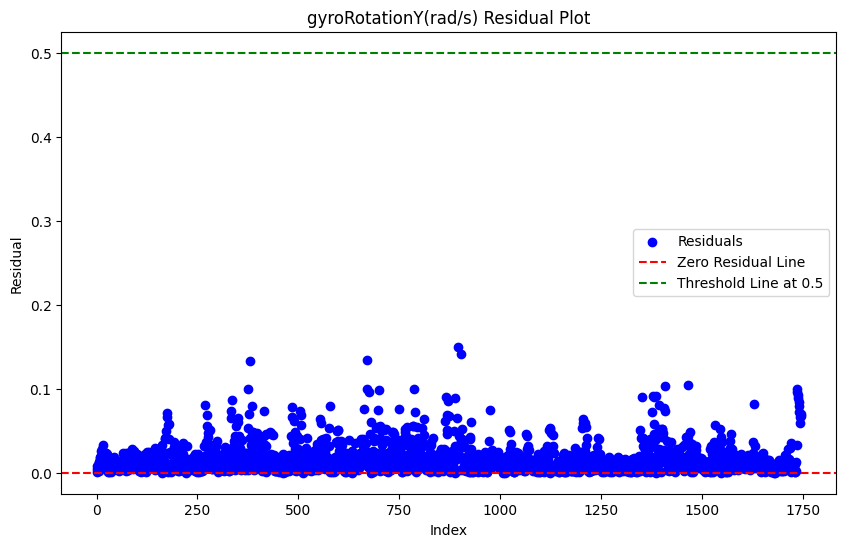

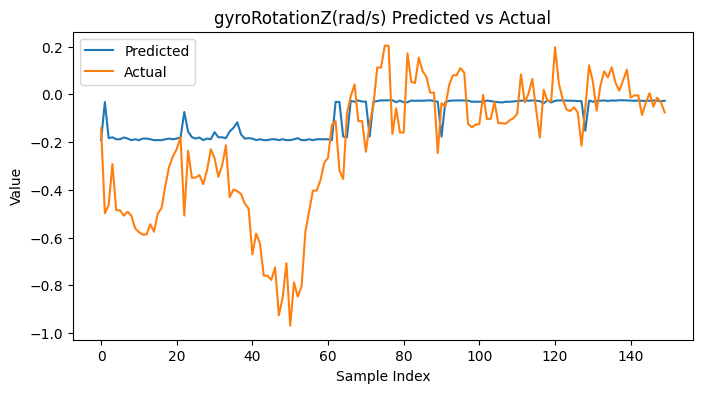

gyroRotationZ(rad/s) RMSE: 0.02537312847043487


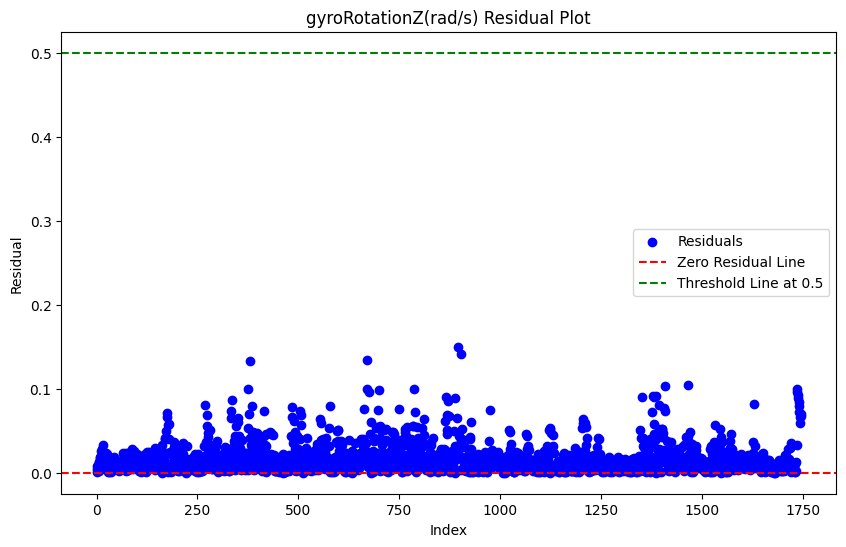

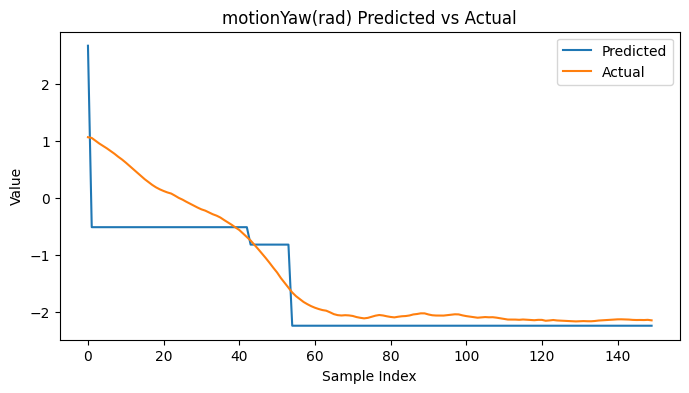

motionYaw(rad) RMSE: 0.02537312847043487


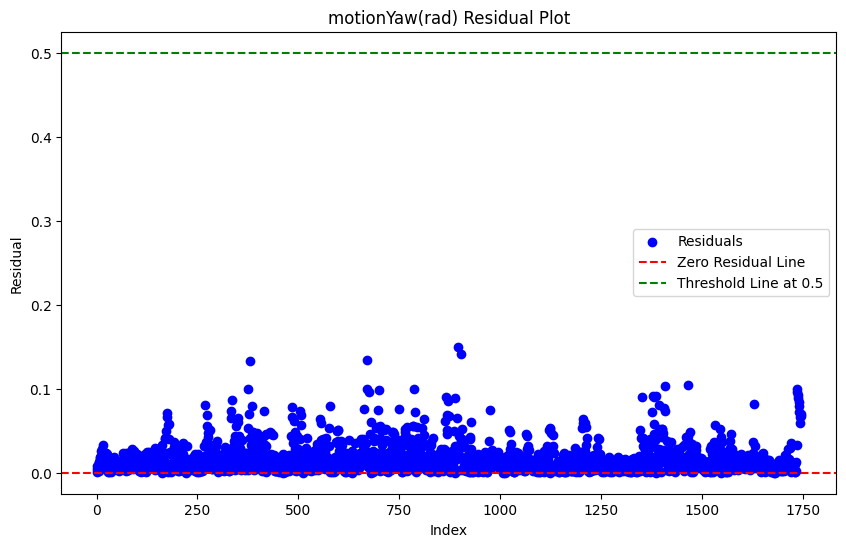

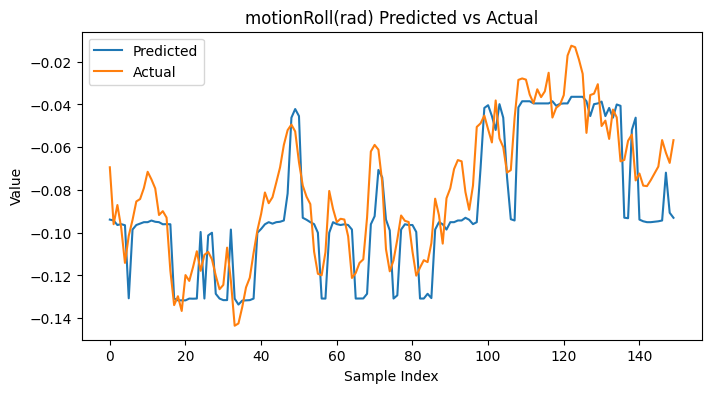

motionRoll(rad) RMSE: 0.02537312847043487


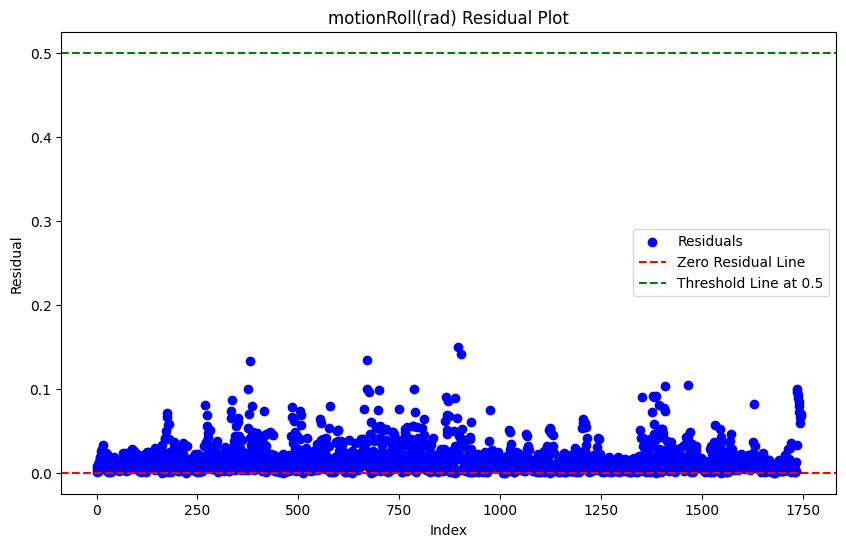

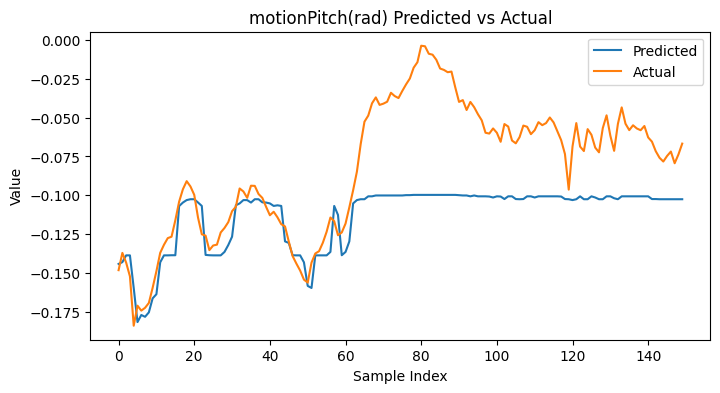

motionPitch(rad) RMSE: 0.02537312847043487


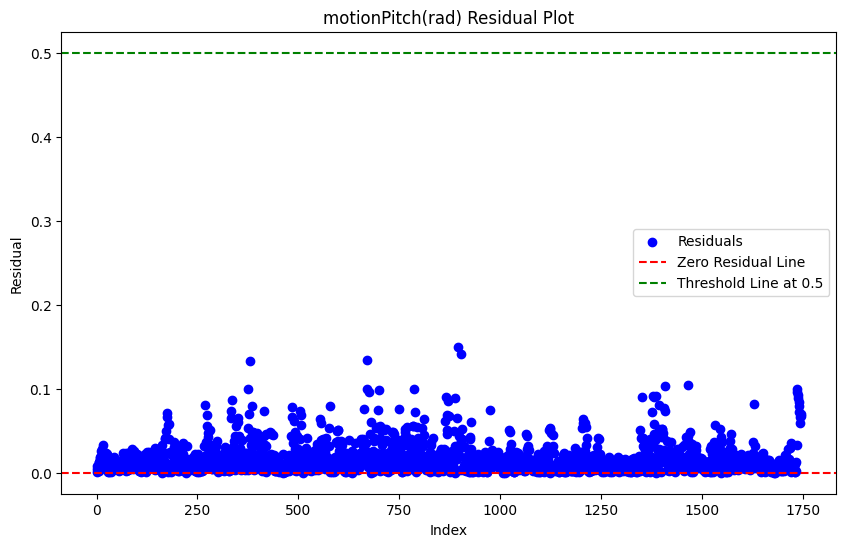

In [ ]:
# Visualize each output separately with corresponding labels for data2
for i in range(num_outputs):  # Loop through accelerometerX, accelerometerY, accelerometerZ
    # Create a DataFrame with predicted and actual values for the current output
    output_data2 = pd.DataFrame(data={'Predicted': test_data_pred2[:, i], 'Actual': y2[:, i]})

    # Plot predicted and actual values
    plt.figure(figsize=(8, 4))
    plt.plot(output_data2['Predicted'][:150], label='Predicted')
    plt.plot(output_data2['Actual'][:150], label='Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'{output_labels[i]} Predicted vs Actual')
    plt.legend()
    plt.show()

     # Calculate RMSE
    output_data['Residual'] = output_data['Predicted'] - output_data['Actual']
    output_data['RMSE'] = np.sqrt(np.square(output_data['Residual']))
    mse = (output_data['Residual'] ** 2).mean()
    rmse = np.sqrt(mse)
    print(f'{output_labels[i]} RMSE: {rmse}')

    # Plot Residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(output_data.index, output_data['RMSE'], color='blue', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold Line at 0.5')  # Threshold line at 0.5
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.title(f'{output_labels[i]} Residual Plot')
    plt.legend()
    plt.show()
